<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="max-width: 250px; display: inline"  alt="Wikistat"/></a>

<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" style="float:right; max-width: 250px; display: inline" alt="IMT"/> </a>
</center>

# Détection d'anomalies dans des données fonctionnelles avec  <a href="https://www.python.org/"><img src="http://python.lycee.free.fr/_images/python-logo.png" style="max-width: 200px; display: inline" alt="R"/></a>

**Résumé** Tutoriel de détection d'anomalies dans des données fonctionnelles. Les données simulées reproduisent les comportement de télémétries observées lors de tests réalisés sur des sattellites avant lancement. Ce sujet est issu du travail de thèse de Clémentine Barreyre chez Airbus Defense and Space. 


** Librairies **
La liste  des *packages* ou librairies que nous utiliserons : 

* la librairie **`pywt`** pour calculer les coefficients d'ondelettes 
* La librairie **`scipy`** pour la classification hiérarchique
* librairie **`scikit-learn`** sera utilisée pour les méthodes `one-class SVM`, `Local Outlier Factor` et `Isolation Random Forest`.   


In [1]:
import pandas as pd
import numpy as np
from statsmodels.robust import mad

# Hierarchical clustering
import scipy.cluster.hierarchy as sch
#Wavelet
import pywt
# LOF
import sklearn.neighbors as sn
# Isolation Forest
import sklearn.ensemble as se

# Plot et Display
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
sb.set_style("darkgrid", {"axes.facecolor": ".9"})

#  Description et lecture des données

On dispose de 480 jours de télémesures. Chaque jour comporte 256 mesures  à intervalles de temps réguliers. Le jeu de données comporte le vecteur des temps et le vecteur des valeurs de la télémesure aux différents instants.

Nous sommes dans un contexte d'apprentissage semi-supervisé : nous savons que les 240 derniers jours ne comportent pas d'anomalies. Les 240 premiers jours comportent quelques anomalies que nous allons chercher à détecter. 



## Lecture des données  et statistiques élémentaires : 


In [2]:
TM=pd.read_csv("TM_Saved_simulated_2017-06-23.dat", index_col=0)
print(TM.describe())
TM.shape

              time.w           TM.w
count  122880.000000  122880.000000
mean      240.001953       0.322124
std       138.564628       1.049180
min         0.003906      -2.657892
25%       120.002930      -0.400796
50%       240.001953       0.123678
75%       360.000977       0.791392
max       480.000000       4.164378


(122880, 2)


Dans un premier temps, on se place donc dans un cadre non supervisé.  On n'utilise  pas l'information fournie par les  240 dernières courbes qui ont été labellisées comme étant exemptes de toute anomalie.
On utilise seulement les 240 premières courbes, qui contiennent un petit nombre d'anomalies. 


In [3]:
TM_480 = TM["TM.w"].values.reshape((480,256))
print(TM_480.shape)
TM_240 = TM_480[:240]
print(TM_240.shape)

(480, 256)
(240, 256)


On précise quelles sont les 8 courbes atypiques. Ceci est inconnu du statisticien et servira seulement pour la validation de nos résultats. 
On introduit des couleurs différentes selon le type d'anomalies :

- 4 anomalies de "forme " représentées en rouge : changement de forme ou d'amplitude des courbes 
- 3 anomalies locales représentées en rose : ajout d'un pic ou de bruit ou d'une valeur atypique
- 1 anomalie de périodicité (deux périodes au lieu d'une) représentée en orange.

In [4]:
ANOMALY_DIC = {0 : "No anomaly", 1 : "Pattern Anomaly", 2 : "Local Anomaly", 3 : "Periodicity Anomaly"}
COLOR_DIC = {0 : "black", 1: "red", 2 : "pink", 3: "orange"}


anomalies = np.zeros(480)
anomalies[[25,219,5,69]] = 1
anomalies[[133,200,155]] = 2
anomalies[[97]] = 3                          
     
TM_480A = list(zip(TM_480, anomalies))



## Tracés de l'ensemble des courbes

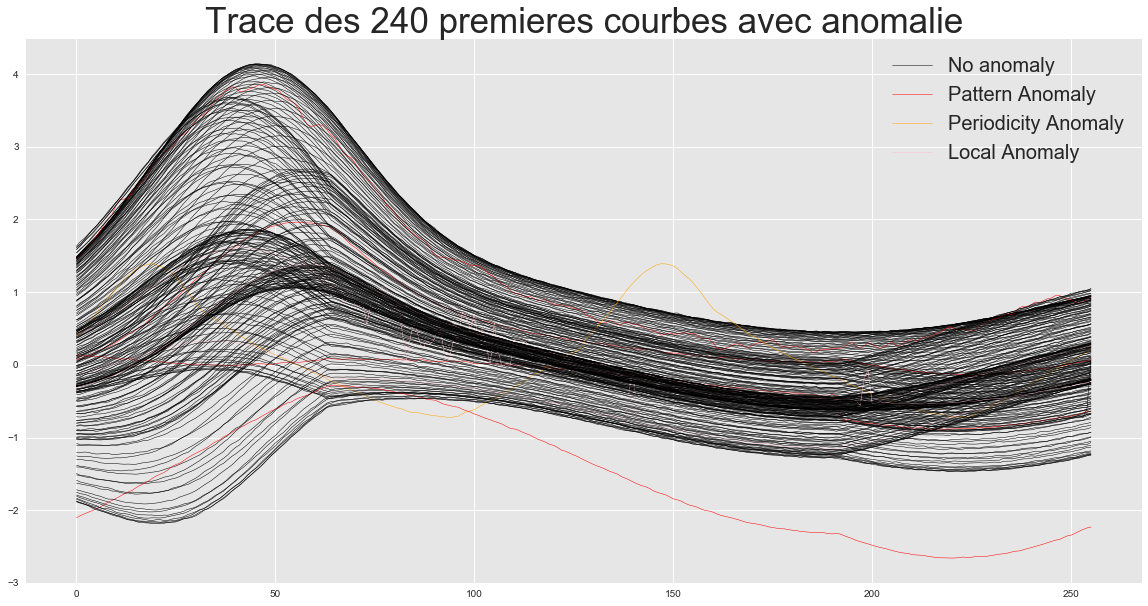

In [5]:
fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
xrange = range(256)
labels = []
for values, anomaly in TM_480A[:240]:
    label = ANOMALY_DIC[anomaly]
    if label in labels:
        ax.plot(xrange, values, color=COLOR_DIC[anomaly], linewidth=0.5)
    else:
        ax.plot(xrange, values, color=COLOR_DIC[anomaly], linewidth=0.5, label=label)
        labels.append(label)
plt.legend(fontsize=20)
ax.set_title("Trace des 240 premieres courbes avec anomalie", fontsize=35)

## Tracé de quelques courbes 

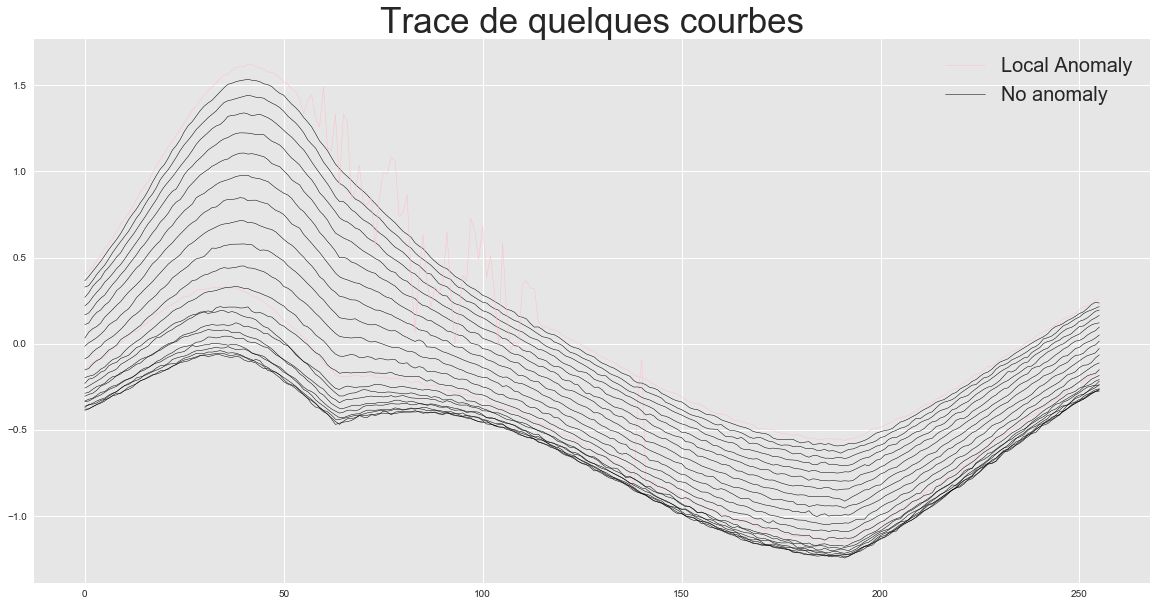

In [6]:
fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
xrange = range(256)
labels = []
for values, anomaly in TM_480A[133:156]:
    label = ANOMALY_DIC[anomaly]
    if label in labels:
        ax.plot(xrange, values, color=COLOR_DIC[anomaly], linewidth=0.5)
    else:
        ax.plot(xrange, values, color=COLOR_DIC[anomaly], linewidth=0.5, label=label)
        labels.append(label)
plt.legend(fontsize=20)
ax.set_title("Trace de quelques courbes", fontsize=35)

## Tracé de l'ensemble des courbes atypiques

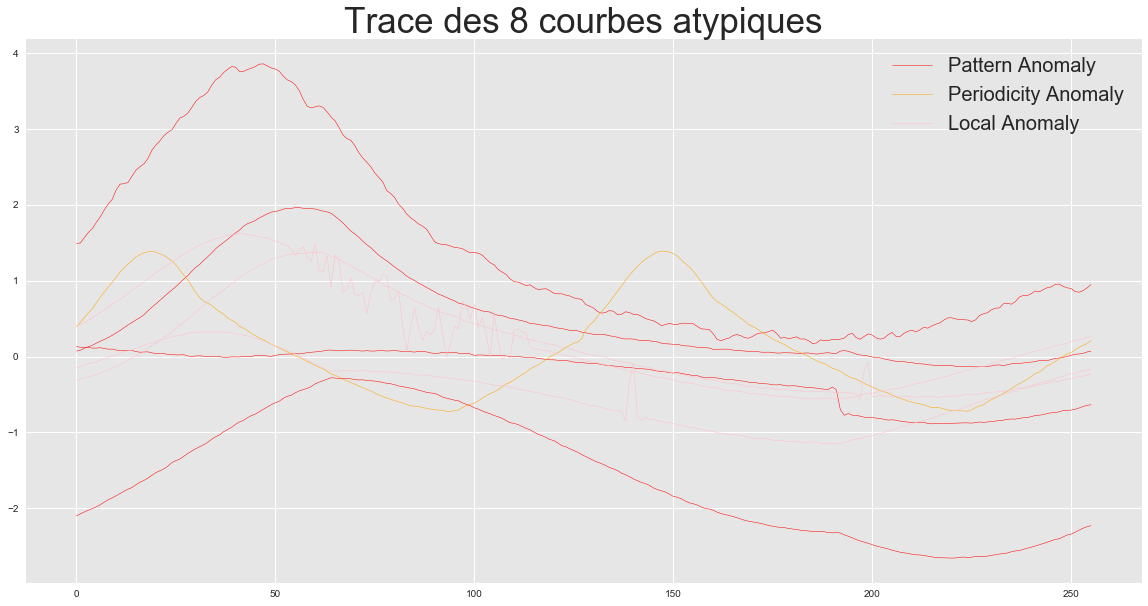

In [7]:
fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
xrange = range(256)
labels = []
for values, anomaly in filter(lambda x : x[1]!=0, TM_480A):
    label = ANOMALY_DIC[anomaly]
    if label in labels:
        ax.plot(xrange, values, color=COLOR_DIC[anomaly], linewidth=0.5)
    else:
        ax.plot(xrange, values, color=COLOR_DIC[anomaly], linewidth=0.5, label=label)
        labels.append(label)
plt.legend(fontsize=20)
ax.set_title("Trace des 8 courbes atypiques", fontsize=35)


## Analyse en composantes principales
### Sur le jeu de données contenant des anomalies

In [8]:
import sklearn.decomposition as sd
import sklearn.preprocessing as sp
acp = sd.PCA()
X_acp = acp.fit_transform(sp.scale(TM_240))

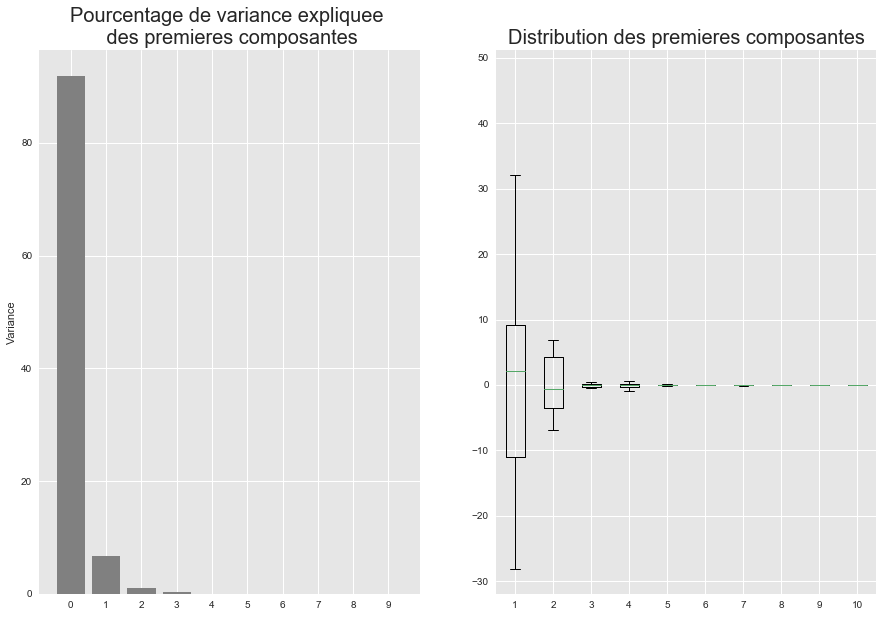

In [9]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
ax.bar(range(10), acp.explained_variance_ratio_[:10]*100, align='center',
        color='grey', ecolor='black')
ax.set_xticks(range(10))
ax.set_ylabel("Variance")
ax.set_title("", fontsize=35)
ax.set_title("Pourcentage de variance expliquee \n des premieres composantes", fontsize=20)

ax = fig.add_subplot(1,2,2)
box=ax.boxplot(X_acp[:,0:10])
ax.set_title("Distribution des premieres composantes", fontsize=20)


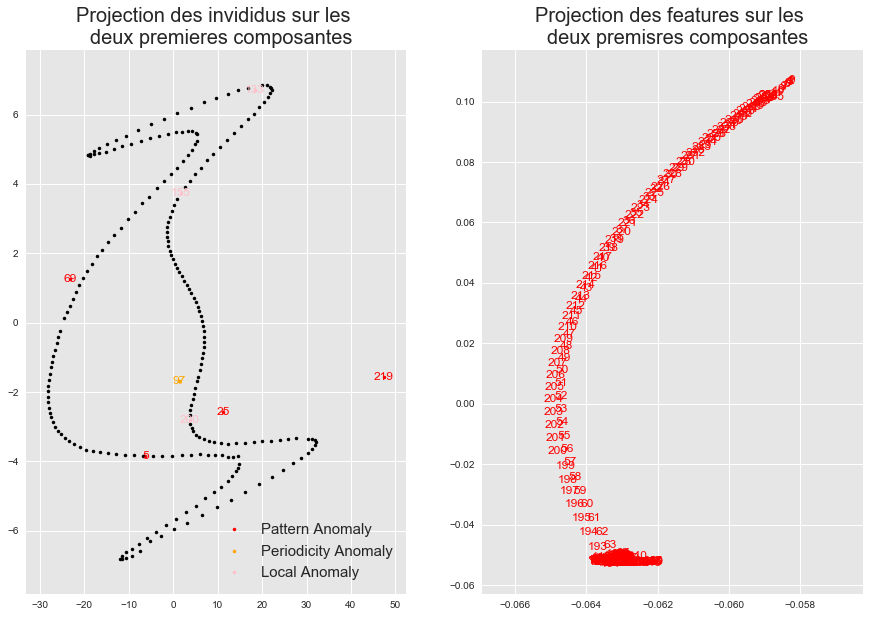

In [10]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
labels=[]
for x,y,s, a in zip(X_acp[:,0], X_acp[:,1], map(str,range(240)), anomalies):
    ax.plot(x,y,marker=".", color=COLOR_DIC[a])
    if a!=0:
        label = ANOMALY_DIC[a]
        ax.text(x,y,s, horizontalalignment="center", verticalalignment="center", color=COLOR_DIC[a])
        if not(label in labels):
            labels.append(label)
            ax.plot(x,y,marker=".", color=COLOR_DIC[a], label = label, linestyle="None")

ax.set_title("Projection des invididus sur les \n  deux premieres composantes", fontsize=20)

ax.set_xlim(X_acp[:,0].min()-5,X_acp[:,0].max()+5)
ax.set_ylim(X_acp[:,1].min()-1,X_acp[:,1].max()+1)
plt.legend(fontsize=15)

ax = fig.add_subplot(1,2,2)
for x,y,s in zip(acp.components_[0], acp.components_[1], map(str,range(256))):
    ax.text(x,y,s, horizontalalignment="center", verticalalignment="center", color="red")
ax.set_xlim(acp.components_[0].min()-0.002,acp.components_[0].max()+0.002)
ax.set_ylim(acp.components_[1].min()-0.01,acp.components_[1].max()+0.01)
ax.set_title("Projection des features sur les \n  deux premisres composantes", fontsize=20)



### Sur le jeu de données ne contenant pas d'anomalies: 

In [11]:
acp2 = sd.PCA()
X_acp2 = acp2.fit_transform(sp.scale(TM_480[240:]))

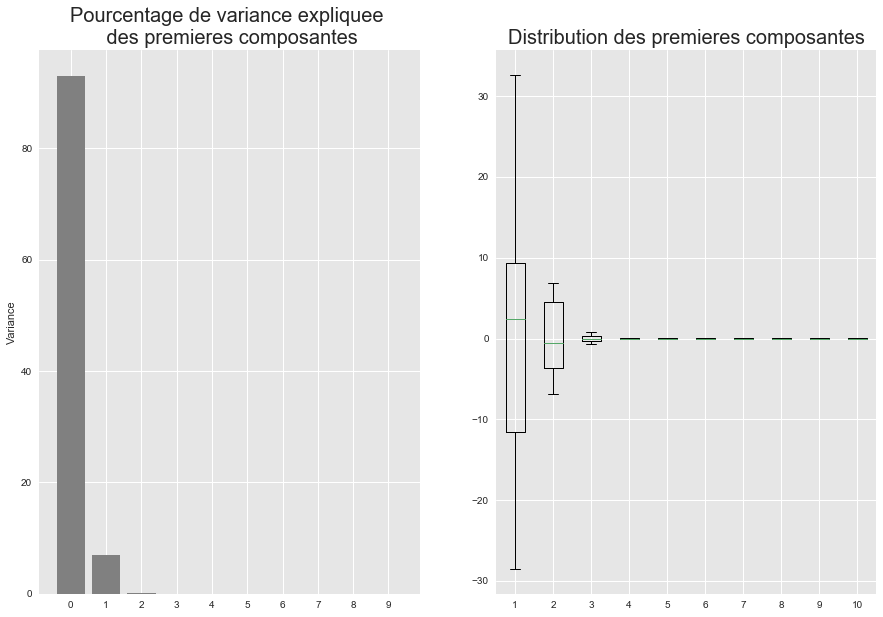

In [12]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
ax.bar(range(10), acp2.explained_variance_ratio_[:10]*100, align='center',
        color='grey', ecolor='black')
ax.set_xticks(range(10))
ax.set_ylabel("Variance")
ax.set_title("Pourcentage de variance expliquee \n des premieres composantes", fontsize=20)

ax = fig.add_subplot(1,2,2)
box=ax.boxplot(X_acp2[:,0:10])
ax.set_title("Distribution des premieres composantes", fontsize=20)


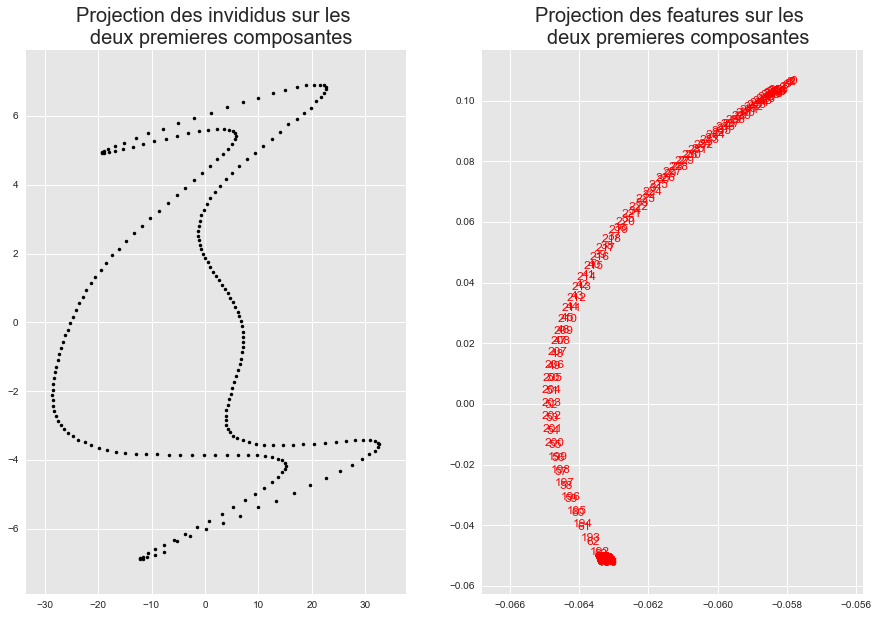

In [13]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
for x,y,s in zip(X_acp2[:,0], X_acp2[:,1], map(str,range(240))):
    ax.plot(x,y, marker=".", color="black")
ax.set_xlim(X_acp2[:,0].min()-5,X_acp2[:,0].max()+5)
ax.set_ylim(X_acp2[:,1].min()-1,X_acp2[:,1].max()+1)
ax.set_title("Projection des invididus sur les \n  deux premieres composantes", fontsize=20)

ax = fig.add_subplot(1,2,2)
for x,y,s in zip(acp2.components_[0], acp2.components_[1], map(str,range(256))):
    ax.text(x,y,s, horizontalalignment="center", verticalalignment="center", color="red")
ax.set_xlim(acp2.components_[0].min()-0.002,acp2.components_[0].max()+0.002)
ax.set_ylim(acp2.components_[1].min()-0.01,acp2.components_[1].max()+0.01)
ax.set_title("Projection des features sur les \n  deux premieres composantes", fontsize=20)


# Définition des features 

Pour détecter les anomalies, on peut utiliser les données brutes, mais ce n'est pas toujours le plus efficace. On peut aussi essayer d'extraire de nouvelles  variables, appelées features, qui permettront peut-être de mettre davantage en lumière les anomalies. Pour cela, on peut par exemple utiliser les coefficients de la projection des données brutes sur des bases orthonormées : base de composantes principales, ou bases d'ondelettes. 


## Coefficients dans la base des composantes principales


In [14]:
# Calcul des Features obtenues à l'aide de l'ACP : 
X_acp480 = acp.transform(TM_480)
index_explained_varianc95 = np.where(np.cumsum(acp.explained_variance_ratio_)>0.95)[0][0]

## Coefficients dans une base d'ondelettes

In [15]:
wf = "haar"

Coeff = []
TCoeff = []
for x in TM_240:
    #Apply wabvelet decomposition
    coeffs = pywt.wavedec(x,wf,level=8)
    coeffs_flatten = np.hstack(coeffs)
    Coeff.append(coeffs_flatten)
    # Compute universal Threshold http://jseabold.net/blog/2012/02/23/wavelet-regression-in-python/
    sigma = mad(coeffs[-1])
    uthresh = sigma*np.sqrt(2*np.log(256))
    # Apply Threshold on 4 fist level
    coeffs_thresh = [pywt.threshold(c, uthresh, mode="hard") if i<=3 else c for i,c in enumerate(coeffs[::-1])]
    coeffs_thresh_flatten = np.hstack(coeffs_thresh[::-1])
    TCoeff.append(coeffs_thresh_flatten)
    
Coeff = np.array(Coeff)
TCoeff = np.array(TCoeff)
print(Coeff.shape, TCoeff.shape)
print(np.sum(Coeff!=0), np.sum(TCoeff!=0))

(240, 256) (240, 256)
61440 17626


## Analyse en composantes principales sur les coefficients d'ondelettes

### Ondelettes de niveau le plus fin J=7 

In [16]:
acp3 = sd.PCA()
X_acp3 = acp3.fit_transform(sp.scale(Coeff[:,128:]))

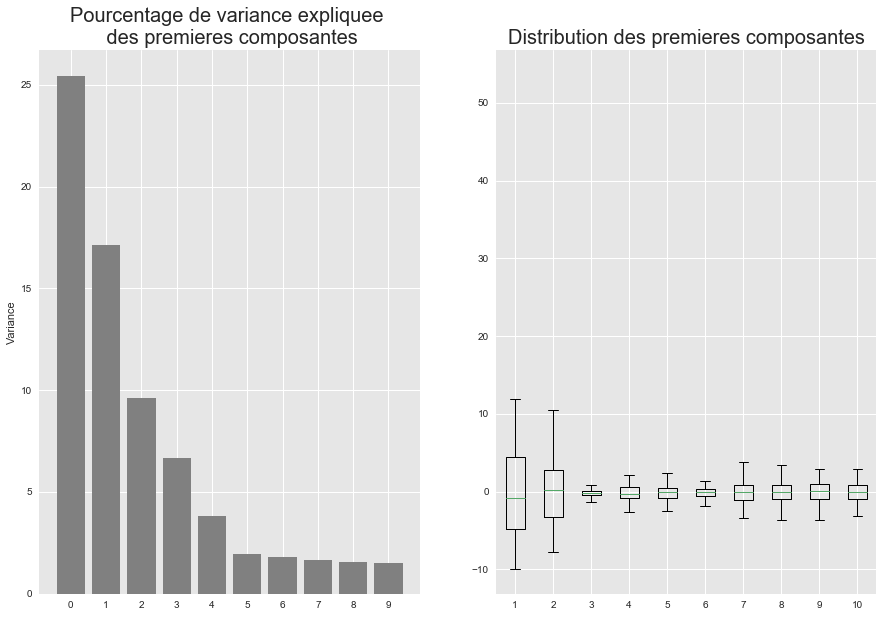

In [17]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
ax.bar(range(10), acp3.explained_variance_ratio_[:10]*100, align='center',
        color='grey', ecolor='black')
ax.set_xticks(range(10))
ax.set_ylabel("Variance")
ax.set_title("Pourcentage de variance expliquee \n des premieres composantes", fontsize=20)

ax = fig.add_subplot(1,2,2)
box=ax.boxplot(X_acp3[:,0:10])
ax.set_title("Distribution des premieres composantes", fontsize=20)


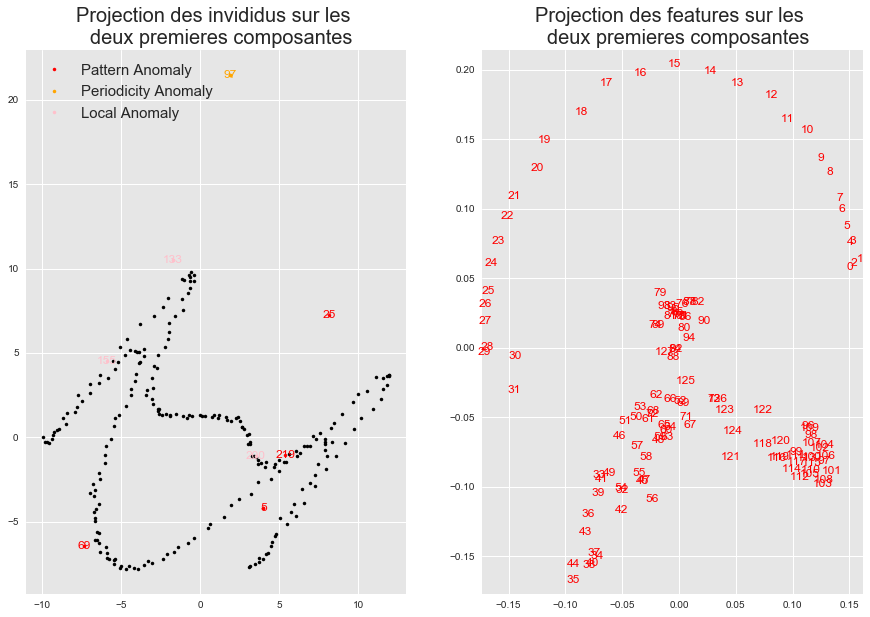

In [18]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
labels=[]
for x,y,s, a in zip(X_acp3[:,0], X_acp3[:,1], map(str,range(240)), anomalies):
    ax.plot(x,y,marker=".", color=COLOR_DIC[a])
    if a!=0:
        label = ANOMALY_DIC[a]
        ax.text(x,y,s, horizontalalignment="center", verticalalignment="center", color=COLOR_DIC[a])
        if not(label in labels):
            labels.append(label)
            ax.plot(x,y,marker=".", color=COLOR_DIC[a], label = label, linestyle="None")
plt.legend(fontsize=15)
ax.set_title("Projection des invididus sur les \n  deux premieres composantes", fontsize=20)


ax = fig.add_subplot(1,2,2)
for x,y,s in zip(acp3.components_[0], acp3.components_[1], map(str,range(256))):
    ax.text(x,y,s, horizontalalignment="center", verticalalignment="center", color="red")
ax.set_xlim(acp3.components_[0].min()-0.002,acp3.components_[0].max()+0.002)
ax.set_ylim(acp3.components_[1].min()-0.01,acp3.components_[1].max()+0.01)
ax.set_title("Projection des features sur les \n  deux premieres composantes", fontsize=20)


### coefficients des niveaux J=0 à  6

In [19]:
acp4 = sd.PCA()
X_acp4 = acp4.fit_transform(sp.scale(Coeff[:,:128]))

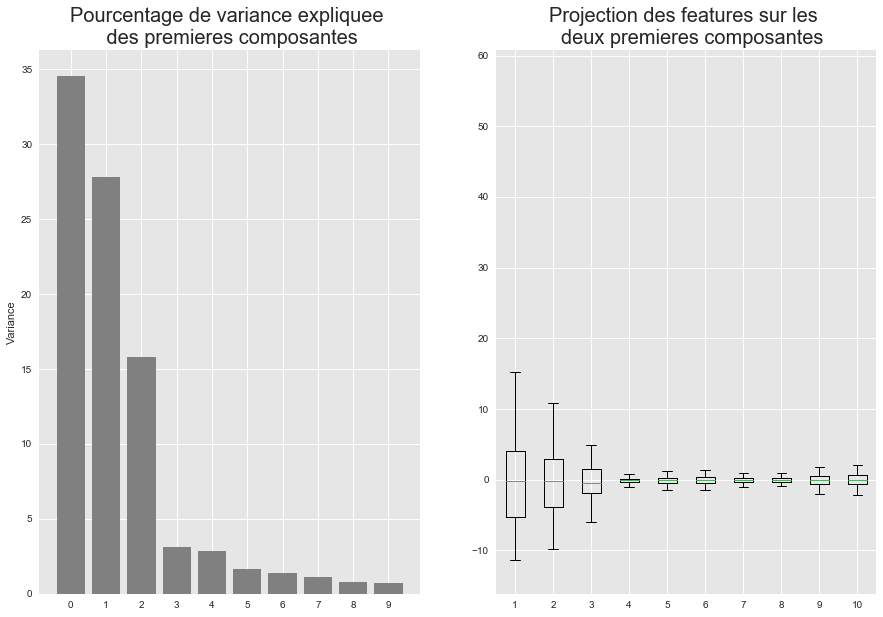

In [20]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
ax.bar(range(10), acp4.explained_variance_ratio_[:10]*100, align='center',
        color='grey', ecolor='black')
ax.set_xticks(range(10))
ax.set_ylabel("Variance")
ax.set_title("Pourcentage de variance expliquee \n des premieres composantes", fontsize=20)

ax = fig.add_subplot(1,2,2)
box=ax.boxplot(X_acp4[:,0:10])
ax.set_title("Distribution des premieres composantes", fontsize=20)
ax.set_title("Projection des features sur les \n  deux premieres composantes", fontsize=20)


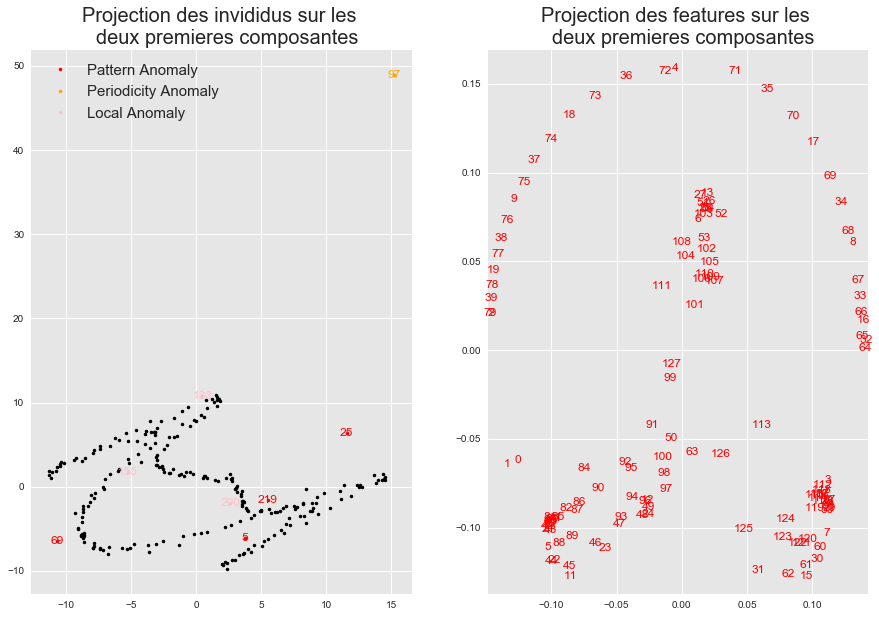

In [21]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
labels=[]
for x,y,s, a in zip(X_acp4[:,0], X_acp4[:,1], map(str,range(240)), anomalies):
    ax.plot(x,y,marker=".", color=COLOR_DIC[a])
    if a!=0:
        label = ANOMALY_DIC[a]
        ax.text(x,y,s, horizontalalignment="center", verticalalignment="center", color=COLOR_DIC[a])
        if not(label in labels):
            labels.append(label)
            ax.plot(x,y,marker=".", color=COLOR_DIC[a], label = label, linestyle="None")
ax.set_title("Projection des invididus sur les \n  deux premieres composantes", fontsize=20)

plt.legend(fontsize=15)

ax = fig.add_subplot(1,2,2)
for x,y,s in zip(acp4.components_[0], acp4.components_[1], map(str,range(256))):
    ax.text(x,y,s, horizontalalignment="center", verticalalignment="center", color="red")
ax.set_xlim(acp4.components_[0].min()-0.002,acp4.components_[0].max()+0.002)
ax.set_ylim(acp4.components_[1].min()-0.01,acp4.components_[1].max()+0.01)
ax.set_title("Projection des features sur les \n  deux premieres composantes", fontsize=20)


### coefficients seuillés : 


In [22]:
acp5 = sd.PCA()
X_acp5 = acp5.fit_transform(sp.scale(TCoeff))

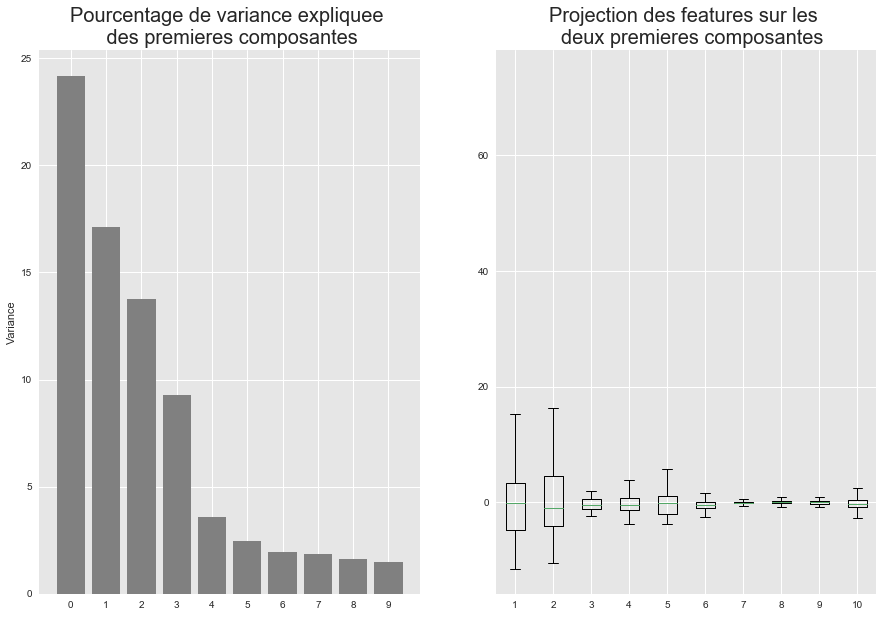

In [23]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
ax.bar(range(10), acp5.explained_variance_ratio_[:10]*100, align='center',
        color='grey', ecolor='black')
ax.set_xticks(range(10))
ax.set_ylabel("Variance")
ax.set_title("Pourcentage de variance expliquee \n des premieres composantes", fontsize=20)

ax = fig.add_subplot(1,2,2)
box=ax.boxplot(X_acp5[:,0:10])
ax.set_title("Distribution des premieres composantes", fontsize=20)
ax.set_title("Projection des features sur les \n  deux premieres composantes", fontsize=20)


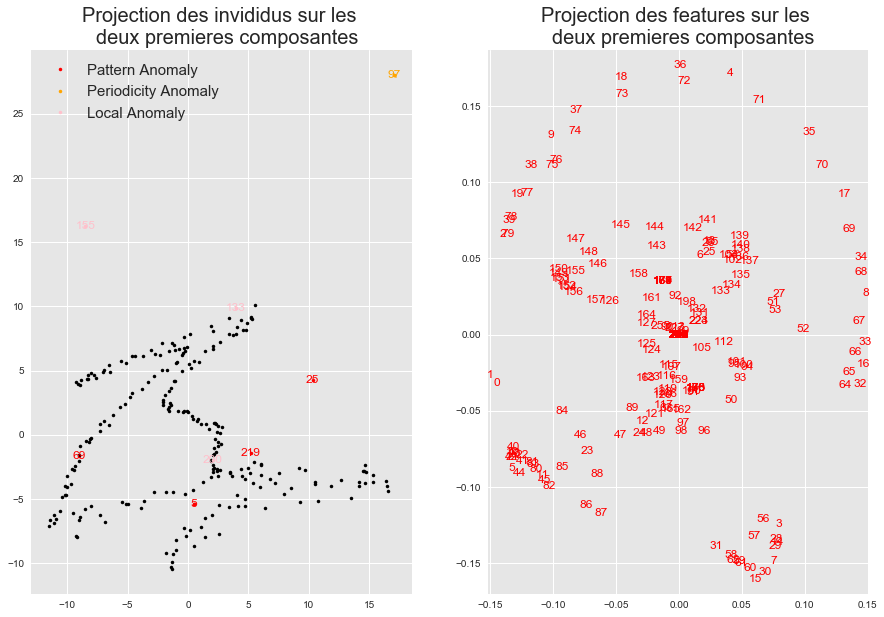

In [24]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
labels=[]
for x,y,s, a in zip(X_acp5[:,0], X_acp5[:,1], map(str,range(240)), anomalies):
    ax.plot(x,y,marker=".", color=COLOR_DIC[a])
    if a!=0:
        label = ANOMALY_DIC[a]
        ax.text(x,y,s, horizontalalignment="center", verticalalignment="center", color=COLOR_DIC[a])
        if not(label in labels):
            labels.append(label)
            ax.plot(x,y,marker=".", color=COLOR_DIC[a], label = label, linestyle="None")
ax.set_title("Projection des invididus sur les \n  deux premieres composantes", fontsize=20)

plt.legend(fontsize=15)

ax = fig.add_subplot(1,2,2)
for x,y,s in zip(acp5.components_[0], acp5.components_[1], map(str,range(256))):
    ax.text(x,y,s, horizontalalignment="center", verticalalignment="center", color="red")
ax.set_xlim(acp5.components_[0].min()-0.002,acp5.components_[0].max()+0.002)
ax.set_ylim(acp5.components_[1].min()-0.01,acp5.components_[1].max()+0.01)
ax.set_title("Projection des features sur les \n  deux premieres composantes", fontsize=20)


# Détection d'anomalies par différentes méthodes
## Classicifation ascendante hierarchique
### Jeu de données ne contenant pas d'anomalies

In [25]:
Z = sch.linkage(TM_480[240:], 'single')
C = np.array([c[0] for c in sch.cut_tree(Z,5)])

CT = pd.DataFrame(list(zip(C,np.zeros(240))), columns=["HCA_cluster","Anomaly"])
display(pd.crosstab(CT.HCA_cluster, CT.Anomaly))

Anomaly,0.0
HCA_cluster,
0,15
1,222
2,1
3,1
4,1


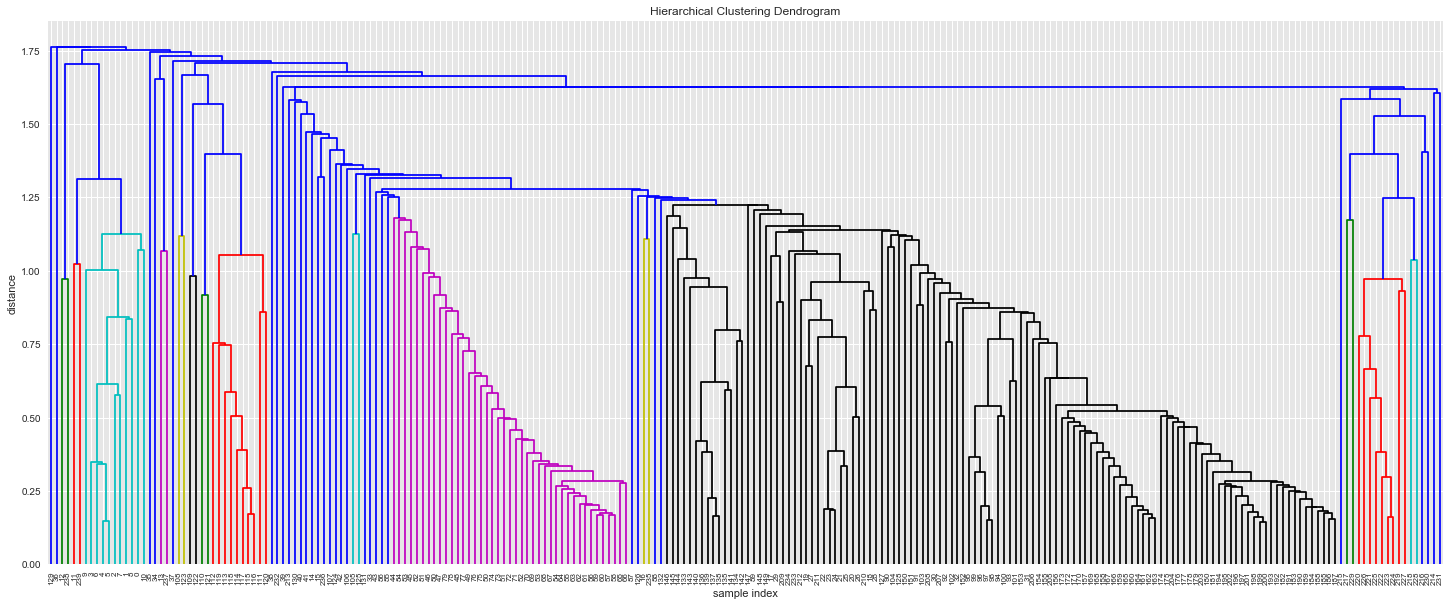

In [26]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
d = sch.dendrogram( Z,p=20, leaf_rotation=90.,leaf_font_size=8.,  # font size for the x axis labels
              )
plt.show()

### #Classif Ascendante Hierarchique sur données brutes

In [27]:
Z = sch.linkage(TM_240, 'single')
C = np.array([c[0] for c in sch.cut_tree(Z,5)])

CT = pd.DataFrame(list(zip(C,anomalies)), columns=["HCA_cluster","Anomaly"])
display(pd.crosstab(CT.HCA_cluster, CT.Anomaly))


Anomaly,0.0,1.0,2.0,3.0
HCA_cluster,,,,
0,232,1,3,0
1,0,1,0,0
2,0,1,0,0
3,0,0,0,1
4,0,1,0,0


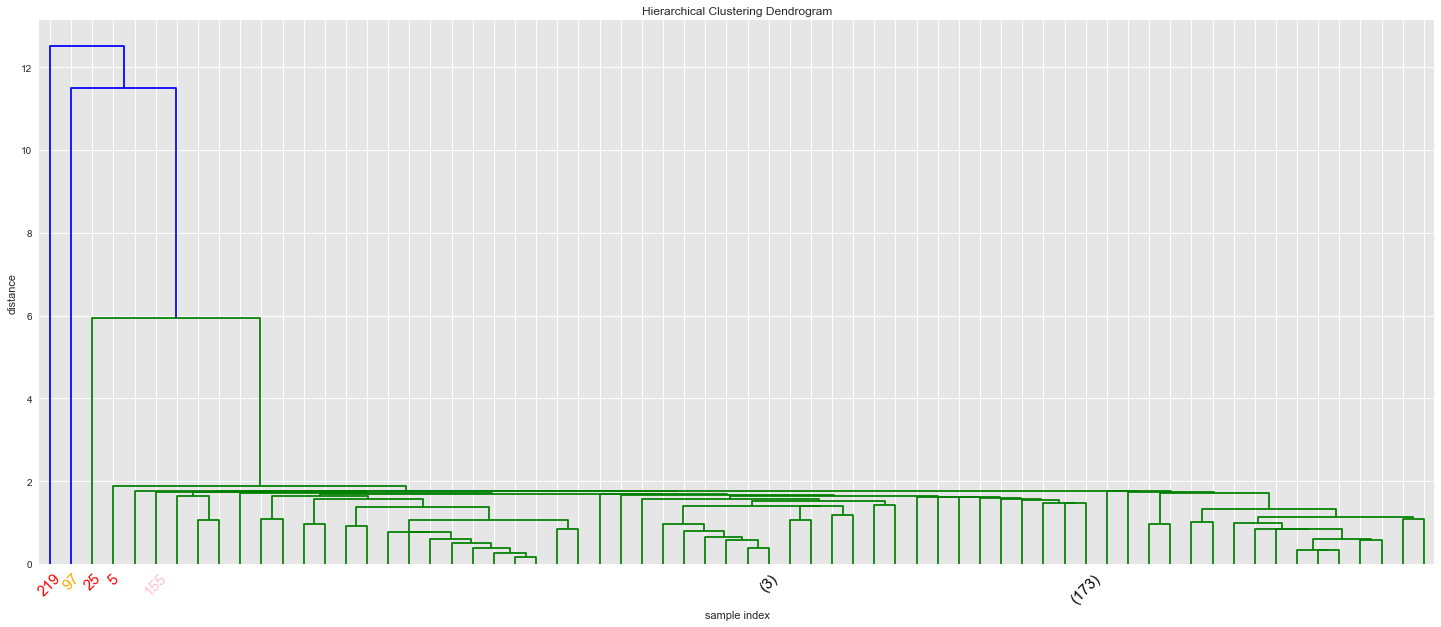

In [28]:
LABELS = [x if x in[25,219,5,69,133,200,155,97]   else "" for x in range(240) ]
fig = plt.figure(figsize=(25, 10))
sch.dendrogram( Z, p=20, leaf_rotation=45.,leaf_font_size=15,labels=LABELS, truncate_mode="level"  # font size for the x axis labels
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')

ax =fig.get_axes()[0]
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    if lbl.get_text() != "":
        lbl.set_color(COLOR_DIC[anomalies[int(lbl.get_text().replace("(","").replace(")","") )]])


plt.show()

### Classif Ascendante Hierarchique sur les  coefficients dans la base des composantes principales: 


In [29]:
Z = sch.linkage(X_acp, 'single')
C = np.array([c[0] for c in sch.cut_tree(Z,5)])

CT = pd.DataFrame(list(zip(C,anomalies)), columns=["HCA_cluster","Anomaly"])
display(pd.crosstab(CT.HCA_cluster, CT.Anomaly))


Anomaly,0.0,1.0,2.0,3.0
HCA_cluster,,,,
0,232,1,3,0
1,0,1,0,0
2,0,1,0,0
3,0,0,0,1
4,0,1,0,0


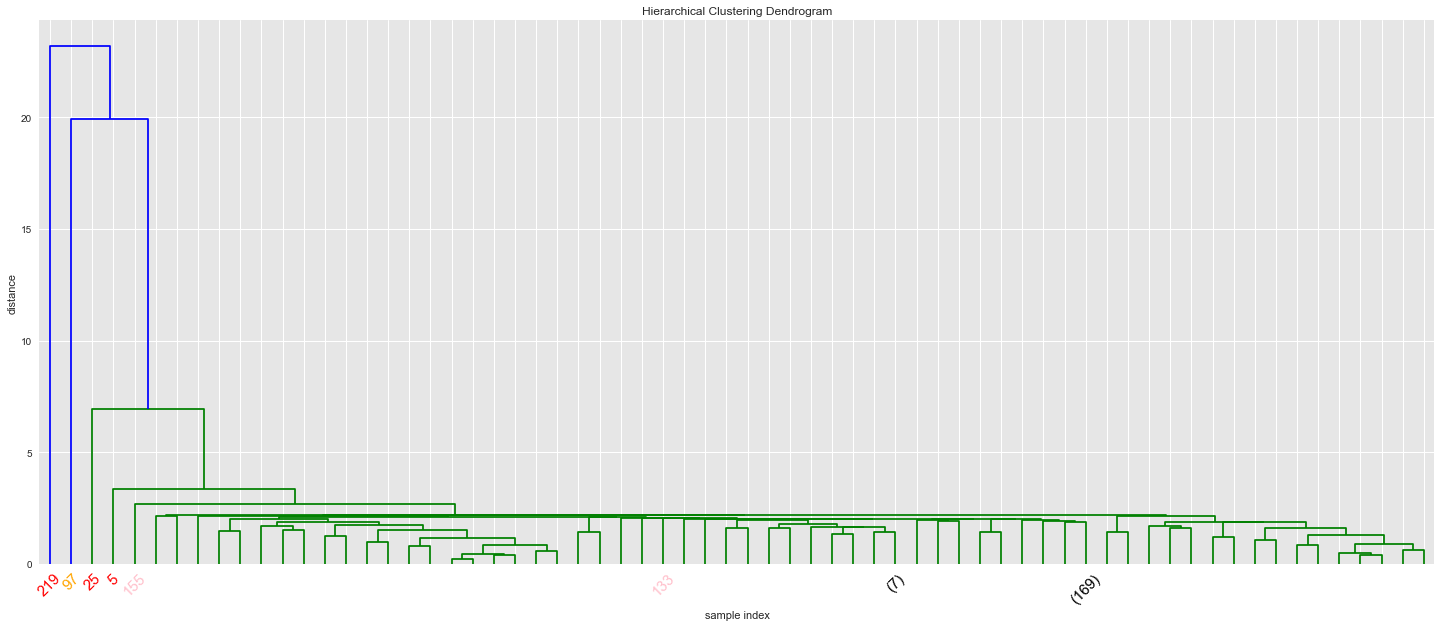

In [30]:
LABELS = [x if x in[25,219,5,69,133,200,155,97]   else "" for x in range(240) ]
fig = plt.figure(figsize=(25, 10))
sch.dendrogram( Z, p=20, leaf_rotation=45.,leaf_font_size=15,labels=LABELS, truncate_mode="level"  # font size for the x axis labels
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')

ax =fig.get_axes()[0]
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    if lbl.get_text() != "":
        lbl.set_color(COLOR_DIC[anomalies[int(lbl.get_text().replace("(","").replace(")","") )]])


plt.show()

### Classif Ascendante Hierarchique sur les  coefficients dans la base des premières composantes principales: 


In [31]:
Z = sch.linkage(X_acp[:,:index_explained_varianc95], 'single')
C = np.array([c[0] for c in sch.cut_tree(Z,5)])

CT = pd.DataFrame(list(zip(C,anomalies)), columns=["HCA_cluster","Anomaly"])
display(pd.crosstab(CT.HCA_cluster, CT.Anomaly))

Anomaly,0.0,1.0,2.0,3.0
HCA_cluster,,,,
0,204,3,2,1
1,15,0,1,0
2,6,0,0,0
3,0,1,0,0
4,7,0,0,0


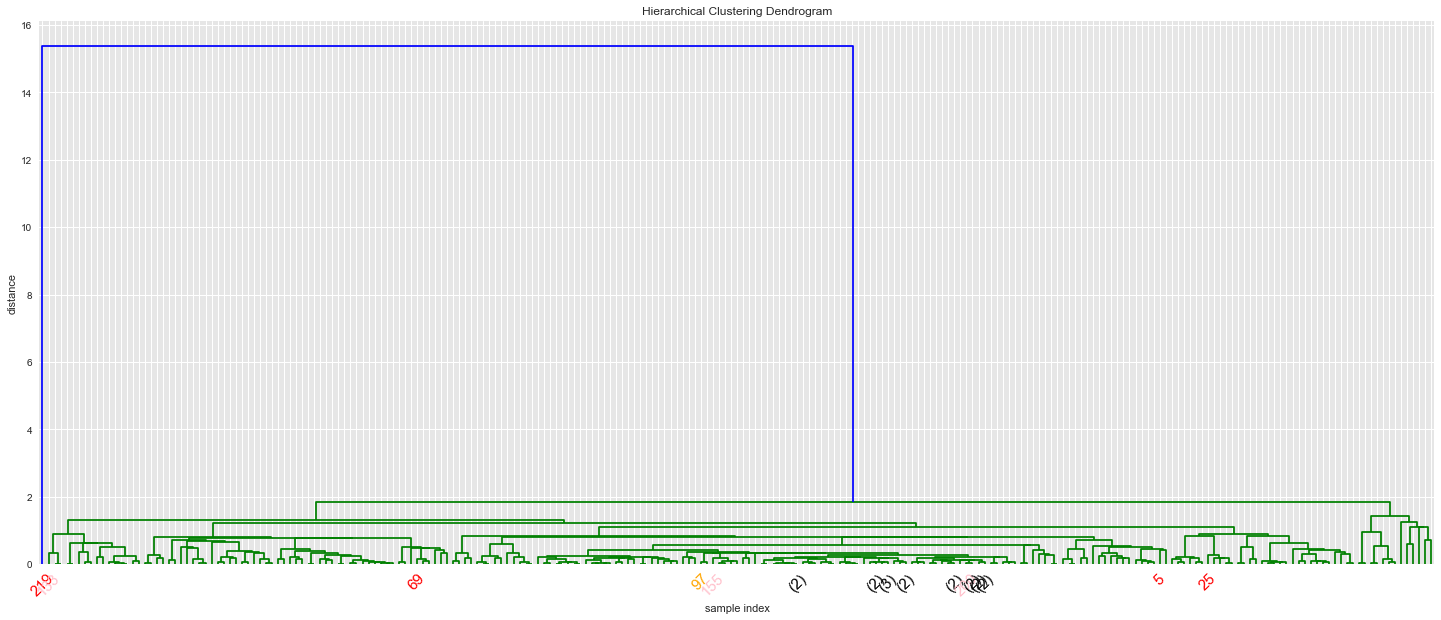

In [32]:
LABELS = [x if x in[25,219,5,69,133,200,155,97]   else "" for x in range(240) ]
fig = plt.figure(figsize=(25, 10))
sch.dendrogram( Z, p=20, leaf_rotation=45.,leaf_font_size=15,labels=LABELS, truncate_mode="level"  # font size for the x axis labels
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')

ax =fig.get_axes()[0]
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    if lbl.get_text() != "":
        lbl.set_color(COLOR_DIC[anomalies[int(lbl.get_text().replace("(","").replace(")","") )]])


plt.show()

### Classif Ascendante Hierarchique sur les  coefficients d'ondelettes: 

In [33]:
Z = sch.linkage(Coeff, 'single')
C = np.array([c[0] for c in sch.cut_tree(Z,5)])

CT = pd.DataFrame(list(zip(C,anomalies)), columns=["HCA_cluster","Anomaly"])
display(pd.crosstab(CT.HCA_cluster, CT.Anomaly))

Anomaly,0.0,1.0,2.0,3.0
HCA_cluster,,,,
0,232,1,3,0
1,0,1,0,0
2,0,1,0,0
3,0,0,0,1
4,0,1,0,0


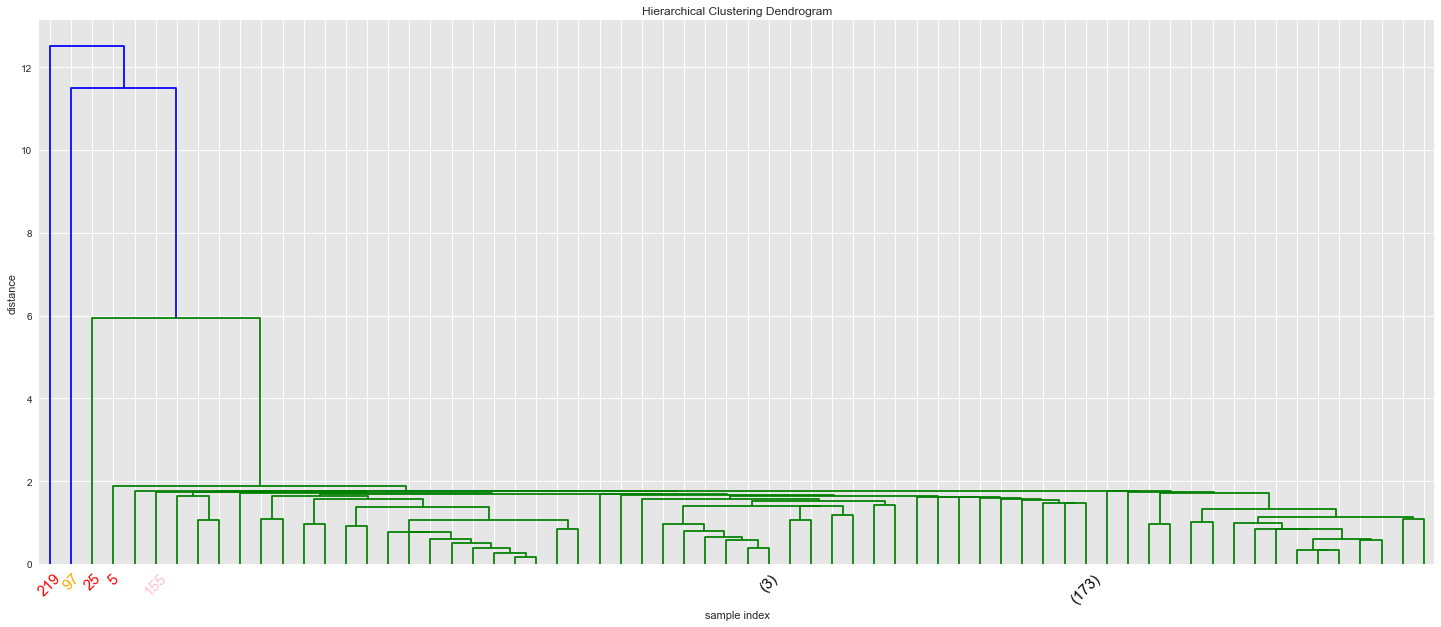

In [34]:
LABELS = [x if x in[25,219,5,69,133,200,155,97]   else "" for x in range(240) ]
fig = plt.figure(figsize=(25, 10))
sch.dendrogram( Z, p=20, leaf_rotation=45.,leaf_font_size=15,labels=LABELS, truncate_mode="level"  # font size for the x axis labels
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')

ax =fig.get_axes()[0]
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    if lbl.get_text() != "":
        lbl.set_color(COLOR_DIC[anomalies[int(lbl.get_text().replace("(","").replace(")","") )]])


plt.show()

### Classif Ascendante Hierarchique sur les  coefficients d'ondelettes de niveau le plus fin: 


In [35]:
Z = sch.linkage(Coeff[:,128:], 'single')
C = np.array([c[0] for c in sch.cut_tree(Z,5)])

CT = pd.DataFrame(list(zip(C,anomalies)), columns=["HCA_cluster","Anomaly"])
display(pd.crosstab(CT.HCA_cluster, CT.Anomaly))

Anomaly,0.0,1.0,2.0,3.0
HCA_cluster,,,,
0,231,4,1,0
1,1,0,0,0
2,0,0,0,1
3,0,0,1,0
4,0,0,1,0


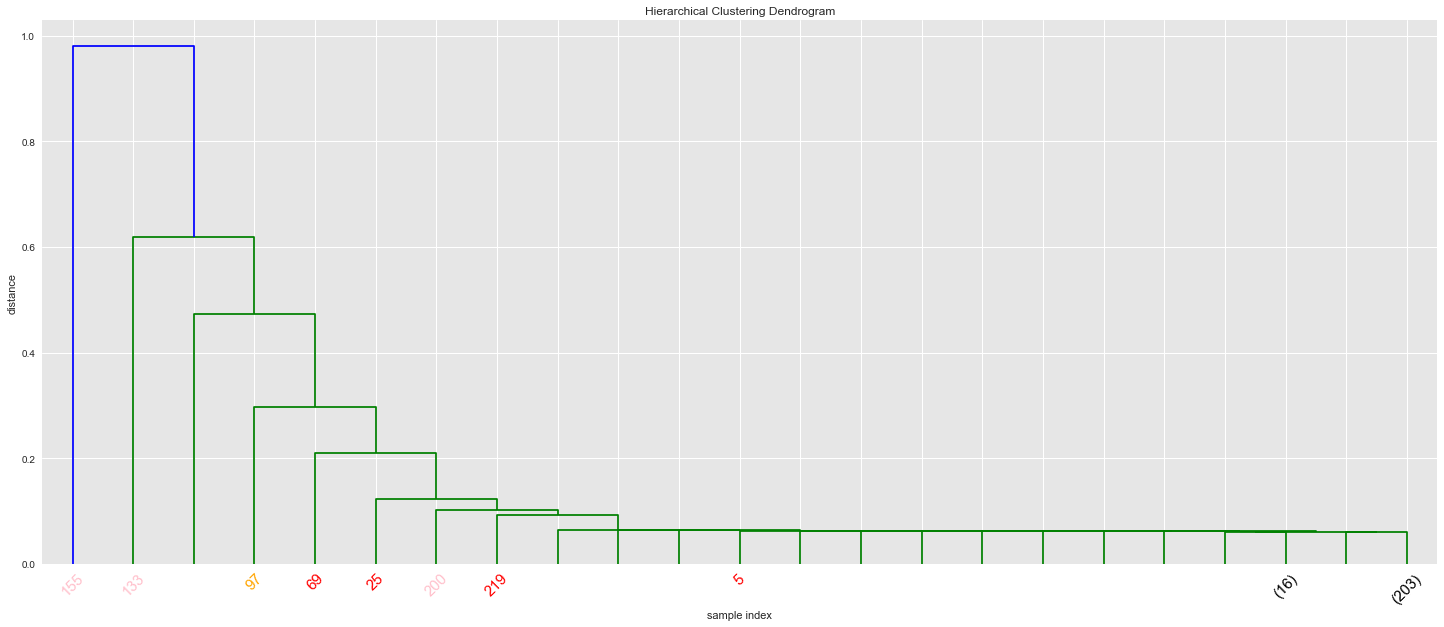

In [36]:
LABELS = [x if x in[25,219,5,69,133,200,155,97]   else "" for x in range(240) ]
fig = plt.figure(figsize=(25, 10))
sch.dendrogram( Z, p=20, leaf_rotation=45.,leaf_font_size=15,labels=LABELS, truncate_mode="level"  # font size for the x axis labels
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')

ax =fig.get_axes()[0]
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    if lbl.get_text() != "":
        lbl.set_color(COLOR_DIC[anomalies[int(lbl.get_text().replace("(","").replace(")","") )]])


plt.show()

### Classif Ascendante Hierarchique sur les  coefficients d'ondelettes de niveaux 0 à 6 


In [37]:
Z = sch.linkage(Coeff[:,:128], 'single')
C = np.array([c[0] for c in sch.cut_tree(Z,5)])

CT = pd.DataFrame(list(zip(C,anomalies)), columns=["HCA_cluster","Anomaly"])
display(pd.crosstab(CT.HCA_cluster, CT.Anomaly))

Anomaly,0.0,1.0,2.0,3.0
HCA_cluster,,,,
0,232,1,3,0
1,0,1,0,0
2,0,1,0,0
3,0,0,0,1
4,0,1,0,0


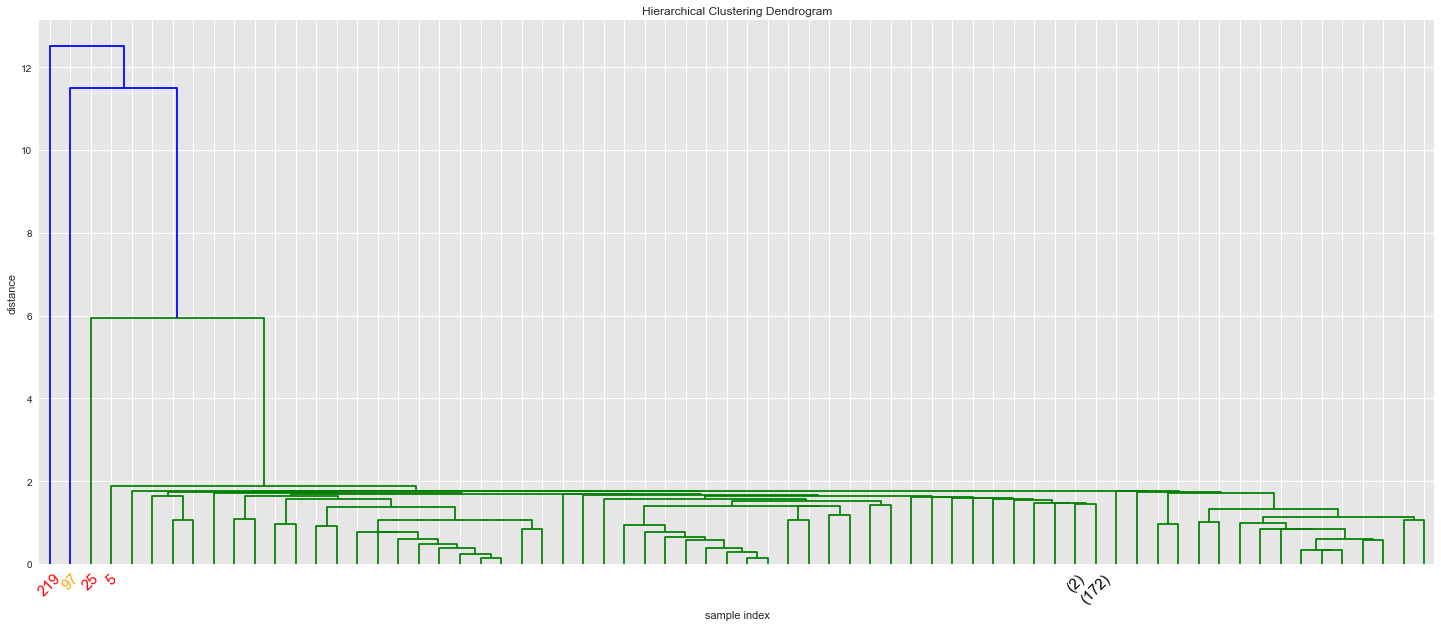

In [38]:
LABELS = [x if x in[25,219,5,69,133,200,155,97]   else "" for x in range(240) ]
fig = plt.figure(figsize=(25, 10))
sch.dendrogram( Z, p=20, leaf_rotation=45.,leaf_font_size=15,labels=LABELS, truncate_mode="level"  # font size for the x axis labels
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')

ax =fig.get_axes()[0]
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    if lbl.get_text() != "":
        lbl.set_color(COLOR_DIC[anomalies[int(lbl.get_text().replace("(","").replace(")","") )]])


plt.show()

### Classif Ascendante Hierarchique sur les  coefficients d'ondelettes  seuillés 


In [39]:
Z = sch.linkage(TCoeff, 'single')
C = np.array([c[0] for c in sch.cut_tree(Z,5)])

CT = pd.DataFrame(list(zip(C,anomalies)), columns=["HCA_cluster","Anomaly"])
display(pd.crosstab(CT.HCA_cluster, CT.Anomaly))

Anomaly,0.0,1.0,2.0,3.0
HCA_cluster,,,,
0,232,1,3,0
1,0,1,0,0
2,0,1,0,0
3,0,0,0,1
4,0,1,0,0


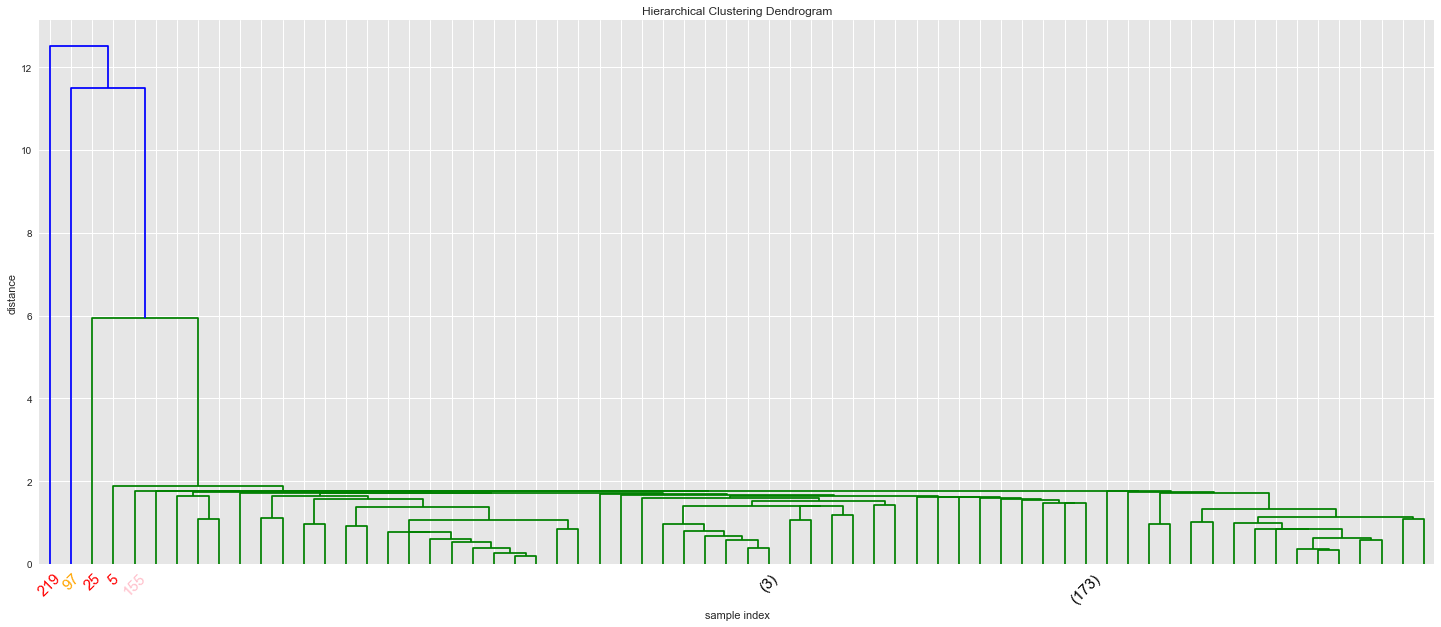

In [40]:
LABELS = [x if x in[25,219,5,69,133,200,155,97]   else "" for x in range(240) ]
fig = plt.figure(figsize=(25, 10))
sch.dendrogram( Z, p=20, leaf_rotation=45.,leaf_font_size=15,labels=LABELS, truncate_mode="level"  # font size for the x axis labels
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')

ax =fig.get_axes()[0]
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    if lbl.get_text() != "":
        lbl.set_color(COLOR_DIC[anomalies[int(lbl.get_text().replace("(","").replace(")","") )]])


plt.show()

** Q ** Comparer les résultats. Quelles jeux de features donnent des résultats comparables ? Lequel donne des résultats différents. Ceci est-il cohérent avec les types d'anomalies considérées ? 

## One Class SVM

### Avec les coefficients dans la base des composantes principales

In [41]:
import sklearn.svm as ssvm
OCS = ssvm.OneClassSVM(nu=0.05)

OCS.fit(X_acp[:,:2])
pred = OCS.predict(X_acp[:,:2])

CT_svm_ACP = pd.DataFrame(list(zip(pred,anomalies)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_svm_ACP.pred, CT_svm_ACP.Anomaly))

Anomaly,0.0,1.0,2.0,3.0
pred,,,,
-1,90,2,2,1
1,142,2,1,0


#### Illustration fonctionement One Class SVM sur les deux premières composantes de l'ACP

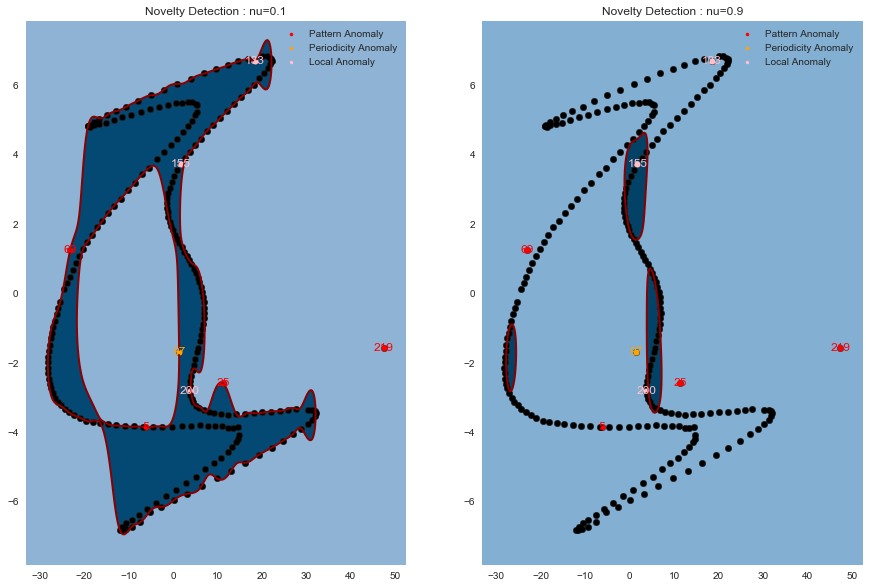

In [42]:
xx, yy = np.meshgrid(np.linspace(X_acp[:,0].min()-5, X_acp[:,0].max()+5, 500), 
                     np.linspace(X_acp[:,1].min()-1, X_acp[:,1].max()+1, 500))

nu = 0.05
# fit the model
clf = ssvm.OneClassSVM(nu=nu, kernel="rbf", gamma=0.1)
clf.fit(X_acp[:,:2])
y_pred_train = clf.predict(X_acp[:,:2])

# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
ax.set_title("Novelty Detection : nu=%.1f" %nu)
ax.contourf(xx, yy, Z, levels=[Z.min(), 0, Z.max()], cmap=plt.cm.PuBu)
a = ax.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')

s = 40
b1 = plt.scatter(X_acp[:,0], X_acp[:,1], c='white', s=s, edgecolors='k')
labels=[]
for x,y,ss, a in zip(X_acp[:,0], X_acp[:,1], map(str,range(240)), anomalies):
    ax.scatter(x,y, c=COLOR_DIC[a],  s=s, edgecolors='k')
    if a!=0:
        label = ANOMALY_DIC[a]
        ax.text(x,y,ss, horizontalalignment="center", verticalalignment="center", color=COLOR_DIC[a])
        if not(label in labels):
            labels.append(label)
            ax.plot(x,y,marker=".", color=COLOR_DIC[a], label = label, linestyle="None")


plt.axis('tight')
ax.set_xlim(X_acp[:,0].min()-5,X_acp[:,0].max()+5)
ax.set_ylim(X_acp[:,1].min()-1,X_acp[:,1].max()+1)
plt.legend()


nu = 0.9
# fit the model
clf = ssvm.OneClassSVM(nu=nu, kernel="rbf", gamma=0.1)
clf.fit(X_acp[:,:2])
y_pred_train = clf.predict(X_acp[:,:2])

# plot the line, the points, and the nearest vectors to the plane
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

ax = fig.add_subplot(1,2,2)
ax.set_title("Novelty Detection : nu=%.1f" %nu)
ax.contourf(xx, yy, Z, levels=[Z.min(), 0, Z.max()], cmap=plt.cm.PuBu)
a = ax.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')

s = 40
b1 = plt.scatter(X_acp[:,0], X_acp[:,1], c='white', s=s, edgecolors='k')
labels=[]
for x,y,ss, a in zip(X_acp[:,0], X_acp[:,1], map(str,range(240)), anomalies):
    ax.scatter(x,y, c=COLOR_DIC[a],  s=s, edgecolors='k')
    if a!=0:
        label = ANOMALY_DIC[a]
        ax.text(x,y,ss, horizontalalignment="center", verticalalignment="center", color=COLOR_DIC[a])
        if not(label in labels):
            labels.append(label)
            ax.plot(x,y,marker=".", color=COLOR_DIC[a], label = label, linestyle="None")


plt.axis('tight')
ax.set_xlim(X_acp[:,0].min()-5,X_acp[:,0].max()+5)
ax.set_ylim(X_acp[:,1].min()-1,X_acp[:,1].max()+1)
plt.legend()


** Q. ** Commenter les résultats et tracer les courbes présentant des anomalies qui sont détectées et celles qui ne le sont pas, ainsi que les fausses alarmes. 

### Avec les coefficients d'ondelettes de niveau le plus fin

In [43]:
import sklearn.svm as ssvm
OCS = ssvm.OneClassSVM(nu=0.05)

OCS.fit(Coeff[:,128:])
pred = OCS.predict(Coeff[:,128:])

CT_svm_ond_fin = pd.DataFrame(list(zip(pred,anomalies)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_svm_ond_fin.pred, CT_svm_ond_fin.Anomaly))

Anomaly,0.0,1.0,2.0,3.0
pred,,,,
-1,3,1,2,1
1,229,3,1,0


### Avec les coefficients d'ondelettes de niveau 0 à 6

In [44]:
import sklearn.svm as ssvm
OCS = ssvm.OneClassSVM(nu=0.05)

OCS.fit(Coeff[:,:128])
pred = OCS.predict(Coeff[:,:128])

CT_svm_ond_06 = pd.DataFrame(list(zip(pred,anomalies)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_svm_ond_06.pred, CT_svm_ond_06.Anomaly))

Anomaly,0.0,1.0,2.0,3.0
pred,,,,
-1,12,1,0,1
1,220,3,3,0


** Q. ** Commenter les résultats obtenus avec les coefficients d'ondelettes et retrouvez quelles sont les courbes atypiques qui sont détectées ainsi que les "faux positifs". 

## Local Outlier Factor
### Avec les coefficients dans la base des composantes principales

In [45]:
contamination=0.033
metric = "euclidean"
clf = sn.LocalOutlierFactor(n_neighbors=5, contamination=contamination, metric=metric)
y_pred = clf.fit_predict(X_acp)

CT_lof_ACP = pd.DataFrame(list(zip(y_pred,anomalies)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_lof_ACP.pred, CT_lof_ACP.Anomaly))

Anomaly,0.0,1.0,2.0,3.0
pred,,,,
-1,3,2,2,1
1,229,2,1,0


### Avec les coefficients dans la base des composantes principales pour les deux premières composantes

In [46]:
contamination=0.033
metric = "euclidean"
clf = sn.LocalOutlierFactor(n_neighbors=5, contamination=contamination, metric=metric)
y_pred = clf.fit_predict(X_acp[:,:2])

CT_lof_ACP2 = pd.DataFrame(list(zip(y_pred,anomalies)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_lof_ACP2.pred, CT_lof_ACP2.Anomaly))

Anomaly,0.0,1.0,2.0,3.0
pred,,,,
-1,6,1,0,1
1,226,3,3,0


#### Illustration fonctionement Local Outlier Factor sur les deux premières composantes de l'ACP

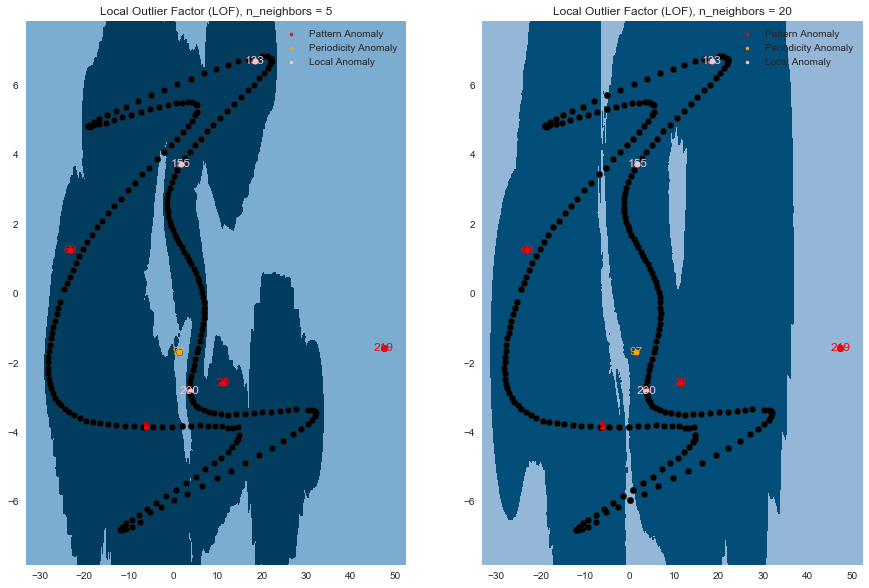

In [47]:
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(1,2,1)

# fit the model
n_neighbors = 5
clf = sn.LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, metric = metric)
y_pred = clf.fit_predict(X_acp[:,:2])

# plot the level sets of the decision function
xx, yy = np.meshgrid(np.linspace(X_acp[:,0].min()-5, X_acp[:,0].max()+5, 500), 
                     np.linspace(X_acp[:,1].min()-1, X_acp[:,1].max()+1, 500))
Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax.set_title("Local Outlier Factor (LOF), n_neighbors = %d" %n_neighbors)
ax.contourf(xx, yy, Z, levels=[Z.min(), clf.threshold_, Z.max()], cmap = plt.cm.PuBu)


s = 40
b1 = plt.scatter(X_acp[:,0], X_acp[:,1], c='white', s=s, edgecolors='k')
labels=[]
for x,y,ss, a in zip(X_acp[:,0], X_acp[:,1], map(str,range(240)), anomalies):
    ax.scatter(x,y, c=COLOR_DIC[a],  s=s, edgecolors='k')
    if a!=0:
        label = ANOMALY_DIC[a]
        ax.text(x,y,ss, horizontalalignment="center", verticalalignment="center", color=COLOR_DIC[a])
        if not(label in labels):
            labels.append(label)
            ax.plot(x,y,marker=".", color=COLOR_DIC[a], label = label, linestyle="None")
plt.legend()


ax = fig.add_subplot(1,2,2)

# fit the model
n_neighbors = 20
clf = sn.LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, metric = metric)
y_pred = clf.fit_predict(X_acp[:,:2])

# plot the level sets of the decision function
xx, yy = np.meshgrid(np.linspace(X_acp[:,0].min()-5, X_acp[:,0].max()+5, 500), 
                     np.linspace(X_acp[:,1].min()-1, X_acp[:,1].max()+1, 500))
Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax.set_title("Local Outlier Factor (LOF), n_neighbors = %d" %n_neighbors)
ax.contourf(xx, yy, Z, levels=[Z.min(), clf.threshold_, Z.max()], cmap = plt.cm.PuBu)


s = 40
b1 = plt.scatter(X_acp[:,0], X_acp[:,1], c='white', s=s, edgecolors='k')
labels=[]
for x,y,ss, a in zip(X_acp[:,0], X_acp[:,1], map(str,range(240)), anomalies):
    ax.scatter(x,y, c=COLOR_DIC[a],  s=s, edgecolors='k')
    if a!=0:
        label = ANOMALY_DIC[a]
        ax.text(x,y,ss, horizontalalignment="center", verticalalignment="center", color=COLOR_DIC[a])
        if not(label in labels):
            labels.append(label)
            ax.plot(x,y,marker=".", color=COLOR_DIC[a], label = label, linestyle="None")
plt.legend()

### Avec les données brutes 

In [48]:
contamination=0.033
metric = "euclidean"
clf = sn.LocalOutlierFactor(n_neighbors=5, contamination=contamination, metric=metric)
y_pred = clf.fit_predict(TM_240)

CT_lof_brut = pd.DataFrame(list(zip(y_pred,anomalies)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_lof_brut.pred, CT_lof_brut.Anomaly))

Anomaly,0.0,1.0,2.0,3.0
pred,,,,
-1,4,2,1,1
1,228,2,2,0


** Q. ** Commenter ces résultats et retrouvez quelles sont les courbes atypiques qui sont détectées ainsi que les "faux positifs"

### Avec tous les coefficients d'ondelettes

In [49]:
contamination=0.033
metric = "euclidean"
clf = sn.LocalOutlierFactor(n_neighbors=5, contamination=contamination, metric=metric)
y_pred = clf.fit_predict(Coeff)

CT_lof_ond_all = pd.DataFrame(list(zip(y_pred,anomalies)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_lof_ond_all.pred, CT_lof_ond_all.Anomaly))

Anomaly,0.0,1.0,2.0,3.0
pred,,,,
-1,4,2,1,1
1,228,2,2,0


### Avec les coefficients d'ondelettes de Niveau le plus fin

In [50]:
contamination=0.033
metric = "euclidean"
clf = sn.LocalOutlierFactor(n_neighbors=5, contamination=contamination, metric=metric)
y_pred = clf.fit_predict(Coeff[:,128:])

CT_lof_ond_fin = pd.DataFrame(list(zip(y_pred,anomalies)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_lof_ond_fin.pred, CT_lof_ond_fin.Anomaly))

Anomaly,0.0,1.0,2.0,3.0
pred,,,,
-1,1,3,3,1
1,231,1,0,0


### Avec les coefficients d'ondelettes de 1 à 6

In [51]:
contamination=0.033
metric = "euclidean"
clf = sn.LocalOutlierFactor(n_neighbors=5, contamination=contamination, metric=metric)
y_pred = clf.fit_predict(Coeff[:,:128])

CT_lof_ond_06 = pd.DataFrame(list(zip(y_pred,anomalies)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_lof_ond_06.pred, CT_lof_ond_06.Anomaly))

Anomaly,0.0,1.0,2.0,3.0
pred,,,,
-1,5,2,0,1
1,227,2,3,0


### Avec les coefficients d'ondelettes seuillés

In [52]:
contamination=0.033
metric = "euclidean"
clf = sn.LocalOutlierFactor(n_neighbors=5, contamination=contamination, metric=metric)
y_pred = clf.fit_predict(TCoeff)

CT_lof_ond_seuil = pd.DataFrame(list(zip(y_pred,anomalies)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_lof_ond_seuil.pred, CT_lof_ond_seuil.Anomaly))

Anomaly,0.0,1.0,2.0,3.0
pred,,,,
-1,4,2,1,1
1,228,2,2,0


## Isolation Forest
### Avec les coefficients dans la base des composantes principales

In [53]:
clf = se.IsolationForest(n_estimators=100, contamination=0.033, bootstrap=True, n_jobs=-1)
clf.fit(X_acp)
y_pred = clf.predict(X_acp)

CT_IF_ACP = pd.DataFrame(list(zip(y_pred,anomalies)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_IF_ACP.pred, CT_IF_ACP.Anomaly))

Anomaly,0.0,1.0,2.0,3.0
pred,,,,
-1,8,0,0,0
1,224,4,3,1


### Avec les coefficients dans la base des composantes principales pour les deux premières composantes


In [54]:
clf = se.IsolationForest(n_estimators=100, contamination=0.033, bootstrap=True, n_jobs=-1)
clf.fit(X_acp[:,:2])
y_pred = clf.predict(X_acp[:,:2])

CT_IF_ACP2 = pd.DataFrame(list(zip(y_pred,anomalies)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_IF_ACP2.pred, CT_IF_ACP2.Anomaly))

Anomaly,0.0,1.0,2.0,3.0
pred,,,,
-1,7,1,0,0
1,225,3,3,1


#### Illustration fonctionement Isolation Forest sur les deux premières composantes de l'ACP

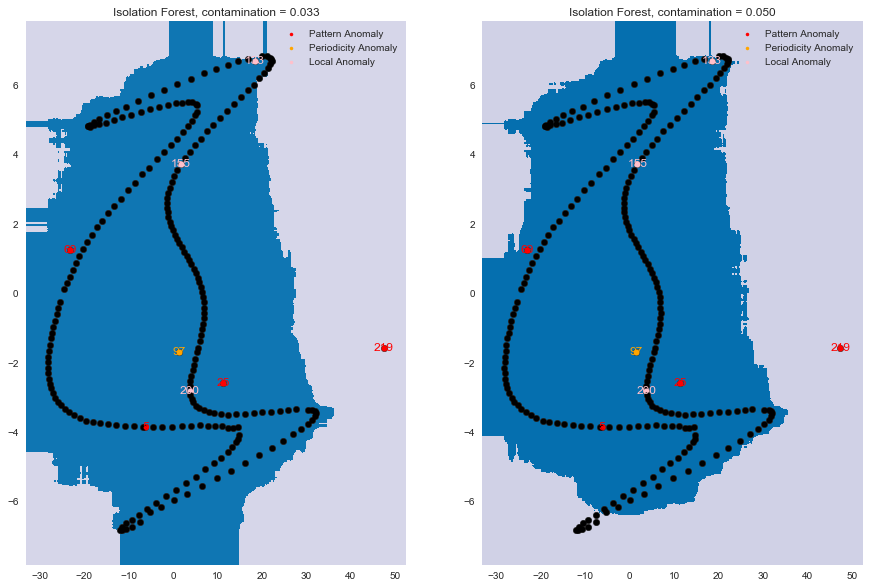

In [55]:
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(1,2,1)

# fit the model
contamination=0.033
clf = se.IsolationForest(n_estimators=100, contamination=contamination, bootstrap=True, n_jobs=-1)
clf.fit(X_acp[:,:2])
y_pred = clf.predict(X_acp[:,:2])


# plot the level sets of the decision function
xx, yy = np.meshgrid(np.linspace(X_acp[:,0].min()-5, X_acp[:,0].max()+5, 500), 
                     np.linspace(X_acp[:,1].min()-1, X_acp[:,1].max()+1, 500))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax.set_title("Isolation Forest, contamination = %.3f" %contamination)
ax.contourf(xx, yy, Z, levels=[Z.min(), clf.threshold_, Z.max()], cmap = plt.cm.PuBu)

s = 40
b1 = plt.scatter(X_acp[:,0], X_acp[:,1], c='white', s=s, edgecolors='k')
labels=[]
for x,y,ss, a in zip(X_acp[:,0], X_acp[:,1], map(str,range(240)), anomalies):
    ax.scatter(x,y, c=COLOR_DIC[a],  s=s, edgecolors='k')
    if a!=0:
        label = ANOMALY_DIC[a]
        ax.text(x,y,ss, horizontalalignment="center", verticalalignment="center", color=COLOR_DIC[a])
        if not(label in labels):
            labels.append(label)
            ax.plot(x,y,marker=".", color=COLOR_DIC[a], label = label, linestyle="None")
plt.legend()


ax = fig.add_subplot(1,2,2)

# fit the model
contamination=0.05
clf = se.IsolationForest(n_estimators=100, contamination=contamination, bootstrap=True, n_jobs=-1)
clf.fit(X_acp[:,:2])
y_pred = clf.predict(X_acp[:,:2])

# plot the level sets of the decision function
xx, yy = np.meshgrid(np.linspace(X_acp[:,0].min()-5, X_acp[:,0].max()+5, 500), 
                     np.linspace(X_acp[:,1].min()-1, X_acp[:,1].max()+1, 500))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax.set_title("Isolation Forest, contamination = %.3f" %contamination)
ax.contourf(xx, yy, Z, levels=[Z.min(), clf.threshold_, Z.max()], cmap = plt.cm.PuBu)


s = 40
b1 = plt.scatter(X_acp[:,0], X_acp[:,1], c='white', s=s, edgecolors='k')
labels=[]
for x,y,ss, a in zip(X_acp[:,0], X_acp[:,1], map(str,range(240)), anomalies):
    ax.scatter(x,y, c=COLOR_DIC[a],  s=s, edgecolors='k')
    if a!=0:
        label = ANOMALY_DIC[a]
        ax.text(x,y,ss, horizontalalignment="center", verticalalignment="center", color=COLOR_DIC[a])
        if not(label in labels):
            labels.append(label)
            ax.plot(x,y,marker=".", color=COLOR_DIC[a], label = label, linestyle="None")
plt.legend()

### Avec les données brutes 

In [56]:
clf = se.IsolationForest(n_estimators=100, contamination=0.033, bootstrap=True, n_jobs=-1)
clf.fit(TM_240)
y_pred = clf.predict(TM_240)

CT_IF_brut = pd.DataFrame(list(zip(y_pred,anomalies)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_IF_brut.pred, CT_IF_brut.Anomaly))

Anomaly,0.0,1.0,2.0,3.0
pred,,,,
-1,6,1,0,1
1,226,3,3,0


### Avec tous les coefficients d'ondelettes

In [57]:
clf = se.IsolationForest(n_estimators=100, contamination=0.033, bootstrap=True, n_jobs=-1)
clf.fit(Coeff)
y_pred = clf.predict(Coeff)

CT_IF_ond = pd.DataFrame(list(zip(y_pred,anomalies)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_IF_ond.pred, CT_IF_ond.Anomaly))

Anomaly,0.0,1.0,2.0,3.0
pred,,,,
-1,3,3,1,1
1,229,1,2,0


### Avec les coefficients d'ondelettes de niveau le plus fin

In [58]:
clf = se.IsolationForest(n_estimators=100, contamination=0.033, bootstrap=True, n_jobs=-1)
clf.fit(Coeff[:,128:])
y_pred = clf.predict(Coeff[:,128:])

CT_IF_ond_fin = pd.DataFrame(list(zip(y_pred,anomalies)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_IF_ond_fin.pred, CT_IF_ond_fin.Anomaly))

Anomaly,0.0,1.0,2.0,3.0
pred,,,,
-1,3,3,1,1
1,229,1,2,0


### Avec les coefficients d'ondelettes de 1 à 6

In [59]:
clf = se.IsolationForest(n_estimators=100, contamination=0.033, bootstrap=True, n_jobs=-1)
clf.fit(Coeff[:,:128])
y_pred = clf.predict(Coeff[:,:128])

CT_IF_ond06 = pd.DataFrame(list(zip(y_pred,anomalies)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_IF_ond06.pred, CT_IF_ond06.Anomaly))

Anomaly,0.0,1.0,2.0,3.0
pred,,,,
-1,1,4,2,1
1,231,0,1,0


### Avec les coefficients d'ondelettes seuillés

In [60]:
clf = se.IsolationForest(n_estimators=100, contamination=0.033, bootstrap=True, n_jobs=-1)
clf.fit(TCoeff)
y_pred = clf.predict(TCoeff)

CT_IF_ondT = pd.DataFrame(list(zip(y_pred,anomalies)), columns=["pred","Anomaly"])
display(pd.crosstab(CT_IF_ondT.pred, CT_IF_ondT.Anomaly))

Anomaly,0.0,1.0,2.0,3.0
pred,,,,
-1,5,1,1,1
1,227,3,2,0


## Visualisation des résultats

### Une fonction pour visualiser les résultats

In [61]:
def make_figure(fig, ax, CT, s1=70, s2=150, legend=True):
    y_lim = (-1.13,1.13)
    x_lim = [-5,260]
    CT_Normal = CT[CT.Anomaly==0]
    CT_Anormal_Detect = CT[np.logical_and(CT.Anomaly!=0,CT.pred==-1)]
    CT_Anormal_NoDetect = CT[np.logical_and(CT.Anomaly!=0,CT.pred==1)]
    ax.scatter(CT_Normal.index, -CT_Normal.pred, s = s1, color="white", edgecolors="black", label = "Normal")
    ax.scatter(CT_Anormal_Detect.index, -CT_Anormal_Detect.pred, s = s2, color="green", edgecolors="black", label= "Anomaly Detected")
    ax.scatter(CT_Anormal_NoDetect.index, -CT_Anormal_NoDetect.pred, s = s2, color="red", edgecolors="black", label ="Anomaly Not detected")
    ax.plot(x_lim, [0,0], color="black")


    for i,x in enumerate([25,219,5,69]) :
        if i == 0:
            ax.plot([x,x] , y_lim, color=COLOR_DIC[1], linestyle="dashed", label = ANOMALY_DIC[1])
        else:
            ax.plot([x,x] , y_lim, color=COLOR_DIC[1], linestyle="dashed")

    for i,x in enumerate([133,200,155]) :
        if i == 0:
            ax.plot([x,x] , y_lim, color=COLOR_DIC[2], linestyle="dashed", label = ANOMALY_DIC[2])
        else:
            ax.plot([x,x] , y_lim, color=COLOR_DIC[2], linestyle="dashed")
    for x in enumerate([97]) :
        if i == 0:
            ax.plot([x,x] , y_lim, color=COLOR_DIC[3], linestyle="dashed", label = ANOMALY_DIC[3])
        else:
            ax.plot([x,x] , y_lim, color=COLOR_DIC[3], linestyle="dashed")


    ax.set_xlim(*x_lim)
    ax.set_ylim(y_lim)
    if legend:
        plt.legend(bbox_to_anchor=(1,1), fontsize=20)

** Q. ** Commenter les résultats obtenus avec les coefficients d'ondelettes et retrouvez quelles sont les courbes atypiques qui sont détectées ainsi que les "faux positifs". Essayez de déterminer comment optimiser le choix du paramètre **k**. 

### Résultats SVM

#### Avec les coefficients dans la base des composantes principales

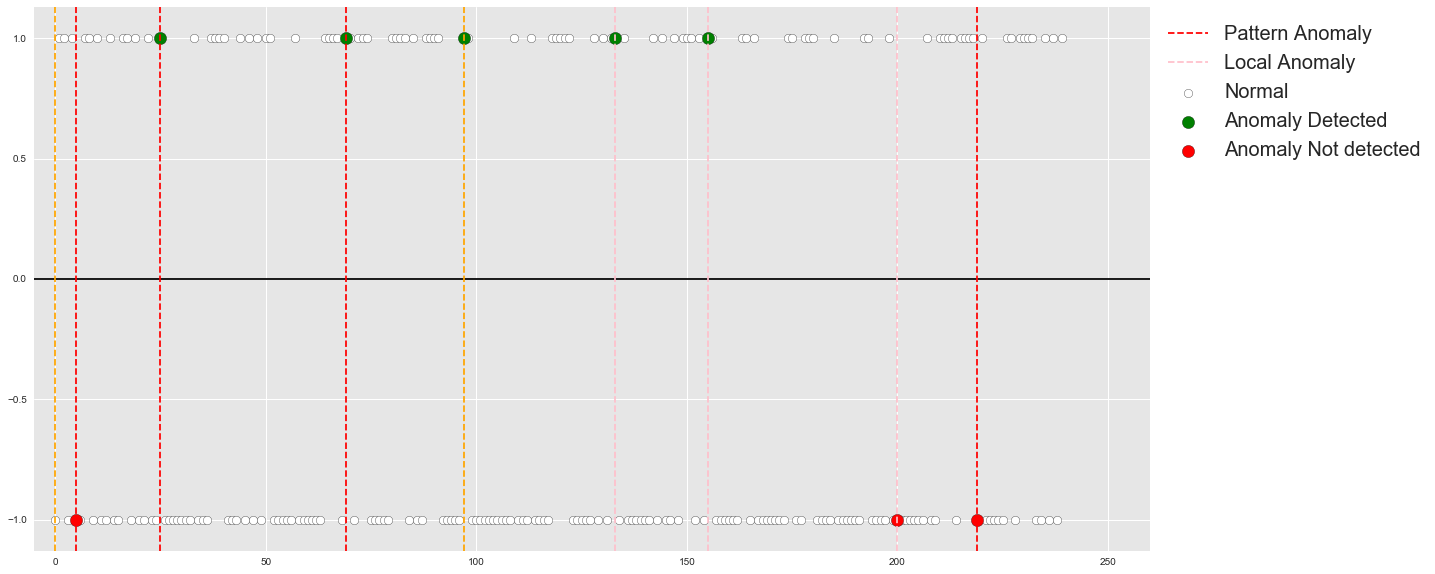

In [62]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
make_figure(fig,ax,CT_svm_ACP)

#### Aves les coefficients d'ondelettes de niveau le plus fin

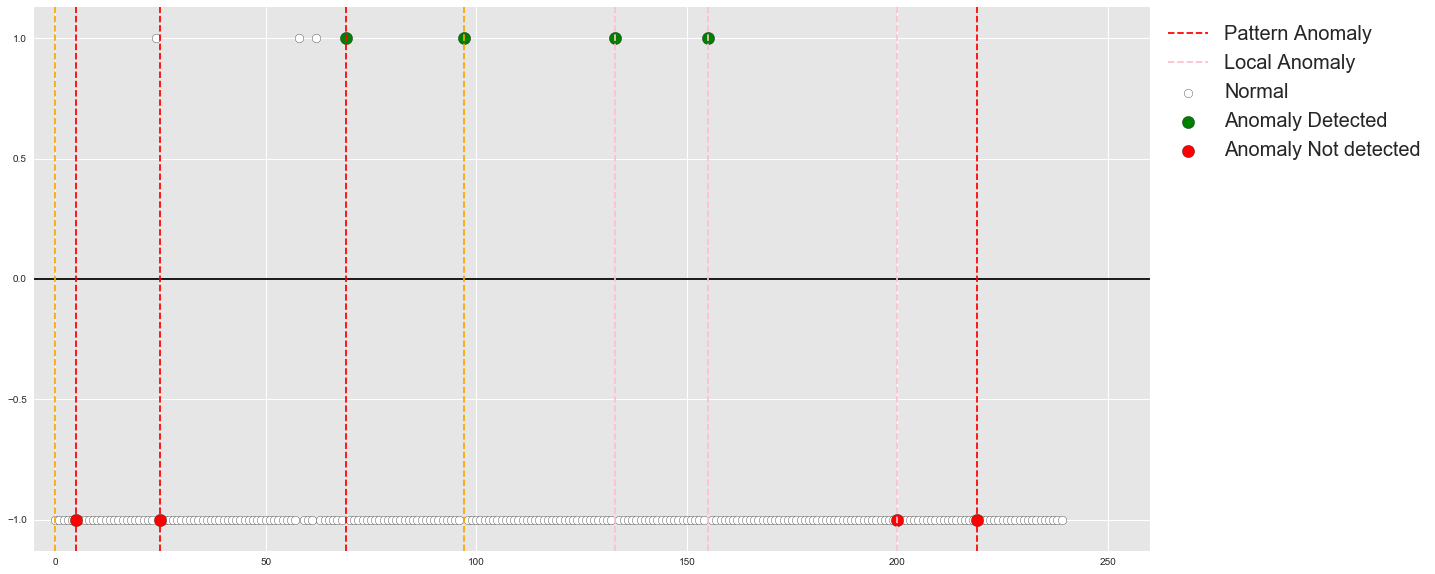

In [63]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
make_figure(fig,ax,CT_svm_ond_fin)

#### Aves les coefficients d'ondelettes de niveau  0 à 6

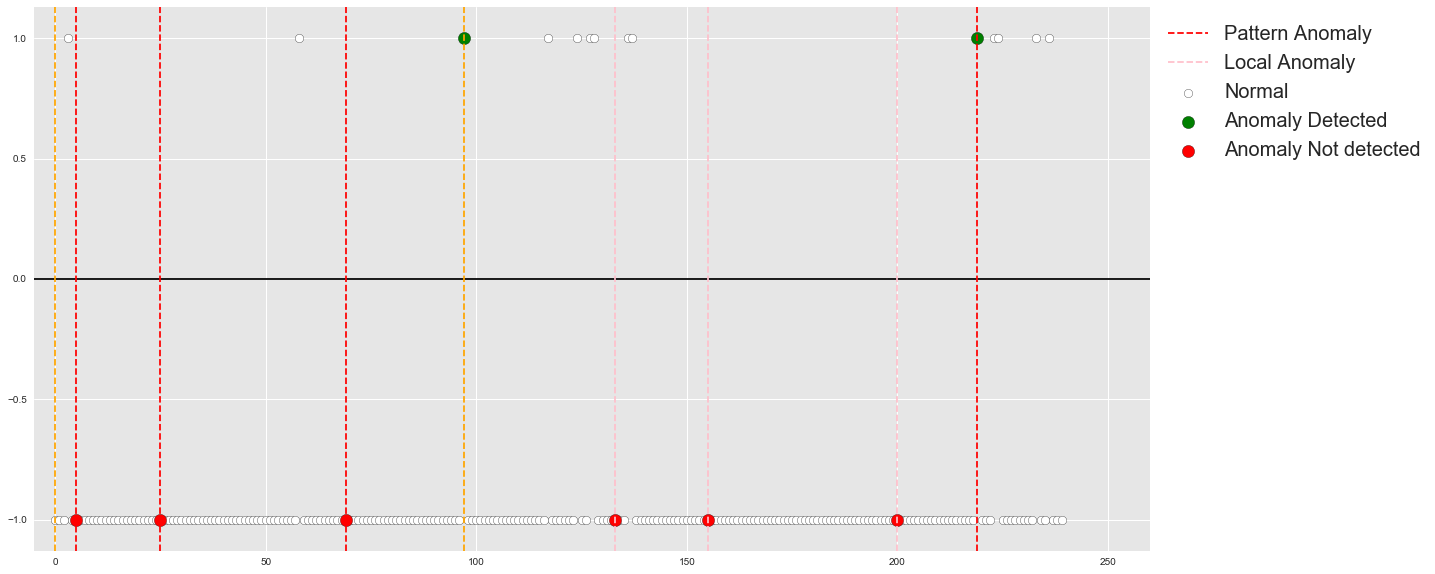

In [64]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
make_figure(fig,ax,CT_svm_ond_06)

### LOF

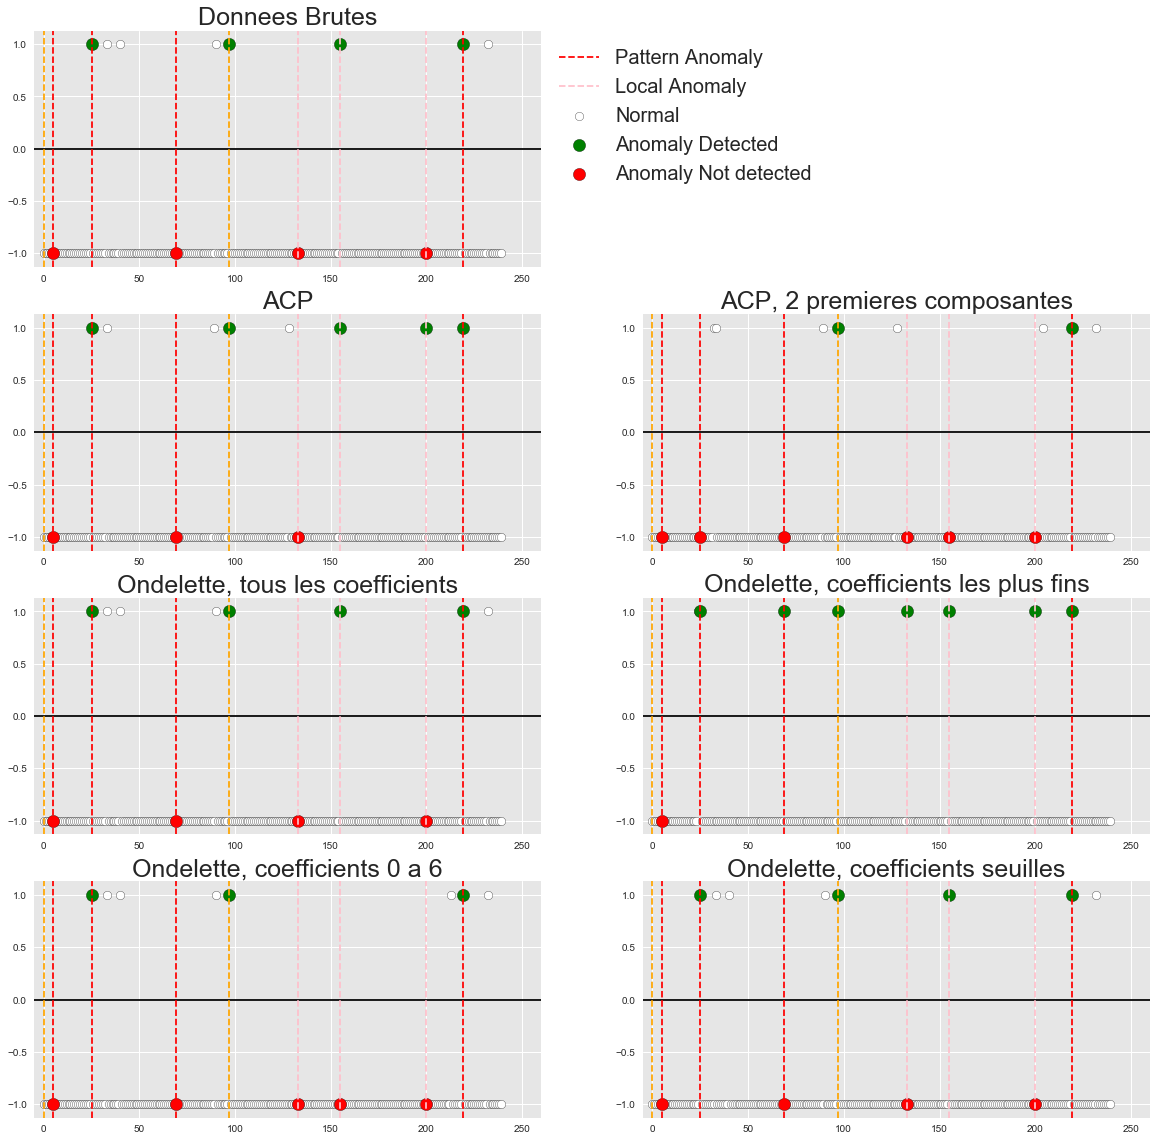

In [65]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(4,2,1)
make_figure(fig,ax,CT_lof_brut, legend=True)
ax.set_title("Donnees Brutes", fontsize=25)
ax = fig.add_subplot(4,2,3)
make_figure(fig,ax,CT_lof_ACP, legend=False)
ax.set_title("ACP", fontsize=25)
ax = fig.add_subplot(4,2,4)
make_figure(fig,ax,CT_lof_ACP2, legend=False)
ax.set_title("ACP, 2 premieres composantes", fontsize=25)
ax = fig.add_subplot(4,2,5)
make_figure(fig,ax,CT_lof_ond_all, legend=False)
ax.set_title("Ondelette, tous les coefficients", fontsize=25)
ax = fig.add_subplot(4,2,6)
make_figure(fig,ax,CT_lof_ond_fin, legend=False)
ax.set_title("Ondelette, coefficients les plus fins", fontsize=25)
ax = fig.add_subplot(4,2,7)
make_figure(fig,ax,CT_lof_ond_06, legend=False)
ax.set_title("Ondelette, coefficients 0 a 6", fontsize=25)
ax = fig.add_subplot(4,2,8)
make_figure(fig,ax,CT_lof_ond_seuil, legend=False)
ax.set_title("Ondelette, coefficients seuilles", fontsize=25)

### Isolation Forest

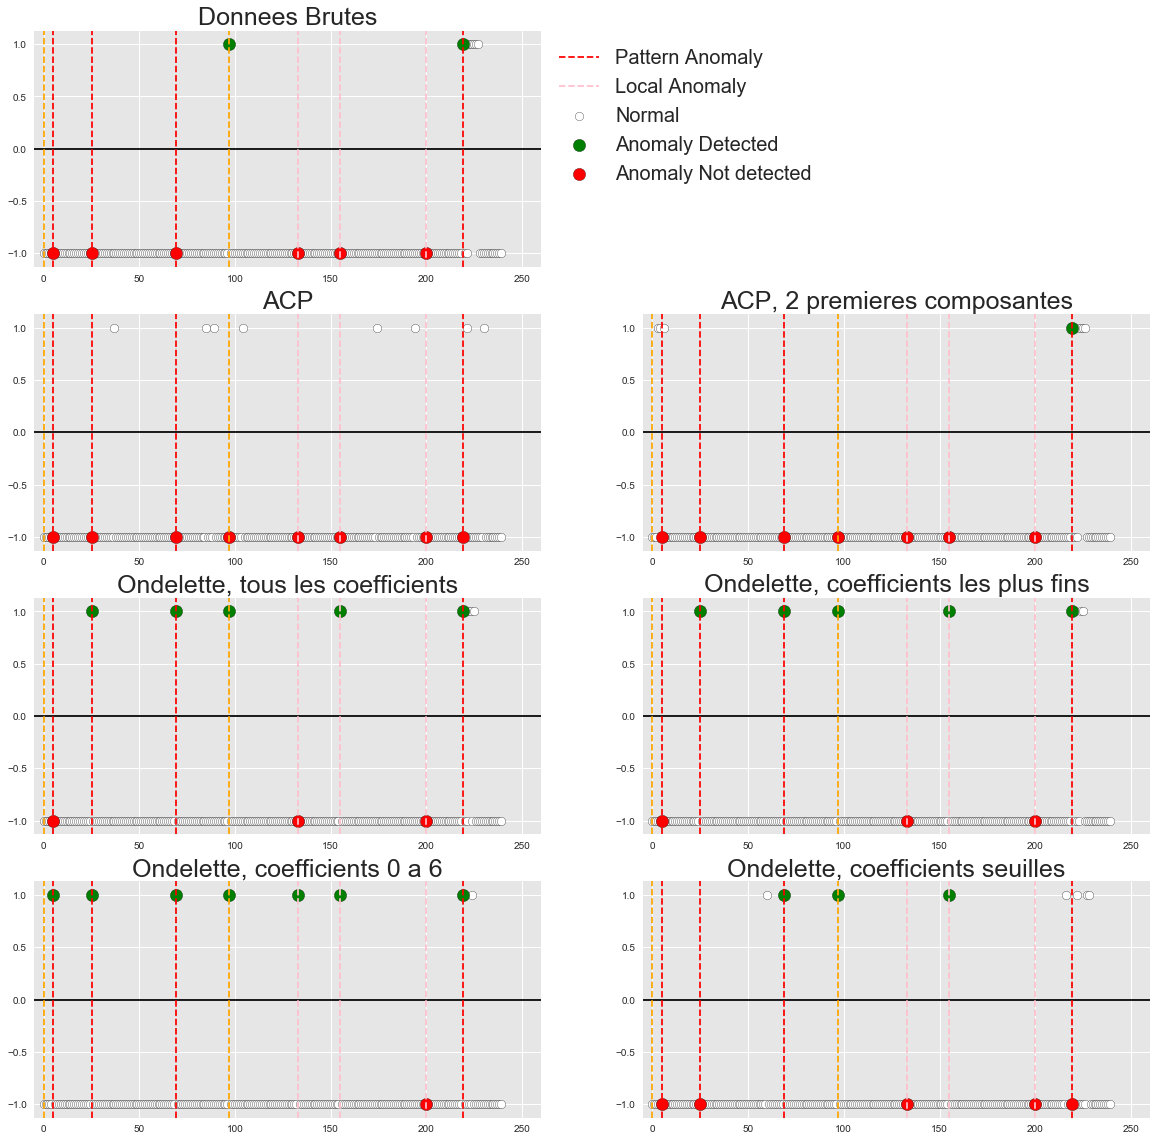

In [66]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(4,2,1)
make_figure(fig,ax,CT_IF_brut, legend=True)
ax.set_title("Donnees Brutes", fontsize=25)
ax = fig.add_subplot(4,2,3)
make_figure(fig,ax,CT_IF_ACP, legend=False)
ax.set_title("ACP", fontsize=25)
ax = fig.add_subplot(4,2,4)
make_figure(fig,ax,CT_IF_ACP2, legend=False)
ax.set_title("ACP, 2 premieres composantes", fontsize=25)
ax = fig.add_subplot(4,2,5)
make_figure(fig,ax,CT_IF_ond, legend=False)
ax.set_title("Ondelette, tous les coefficients", fontsize=25)
ax = fig.add_subplot(4,2,6)
make_figure(fig,ax,CT_IF_ond_fin, legend=False)
ax.set_title("Ondelette, coefficients les plus fins", fontsize=25)
ax = fig.add_subplot(4,2,7)
make_figure(fig,ax,CT_IF_ond06, legend=False)
ax.set_title("Ondelette, coefficients 0 a 6", fontsize=25)
ax = fig.add_subplot(4,2,8)
make_figure(fig,ax,CT_IF_ondT, legend=False)
ax.set_title("Ondelette, coefficients seuilles", fontsize=25)